# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from matplotlib.transforms import TransformedBbox
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches
import seaborn as sb

from IPython import get_ipython
import pandas as pd
import numpy as np
import vaex
import scipy
from scipy.stats import chi2_contingency
import itertools
from collections import defaultdict

# Options for pandas
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 600
pd.options.display.max_rows = 30

# Display all cell outputs
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = 'all'

ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
# Set default font size
plt.rcParams['font.size'] = 24
# Set default font size
sb.set(font_scale=.8)
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sb.set_style("white", rc=custom_style)

In [3]:
ordered_AAs = ['GLY', 'ALA', 'PRO', 'CYS', 'MET', 'ILE', 'LEU', 'VAL', 'PHE', 'TRP',
               'TYR', 'HIS', 'ARG', 'LYS', 'GLN', 'ASN', 'ASP', 'GLU', 'SER', 'THR']

AA_dict_low = {
    'carboxyamine': ['GLN', 'ASN'],
    'positive': ['HIS', 'ARG', 'LYS'],
    'hydroxyl': ['SER', 'THR'],
    'aliphatic': ['ILE', 'LEU', 'VAL'],
    'aromatic': ['PHE', 'TRP', 'TYR'],
    'negative': ['ASP', 'GLU']}

AA_dict_high = {
    "hydrophobic": ['GLY', 'ALA', 'PRO', 'CYS', 'MET', 'ILE', 'LEU', 'VAL', 'PHE'],
    "polar": ['TRP',
              'TYR', 'HIS', 'ARG', 'LYS', 'GLN', 'ASN', 'ASP', 'GLU', 'SER', 'THR']
}

# ROTAs sorted by pysicochemical properties
ordered_ROTAs = ['GLY', 'ALA'] + ['PRO1', 'PRO2']
trios = ['CYS', 'MET', 'ILE', 'LEU', 'VAL', 'PHE', 'TRP', 'TYR',
         'HIS', 'ARG', 'LYS', 'GLN', 'ASN', 'ASP', 'GLU', 'SER', 'THR']


def make_ROTA_trios(AAs):
    out = []
    for AA in AAs:
        out.extend([AA + n for n in ["1", "2", "3"]])
    return out


ordered_ROTAs = ordered_ROTAs + make_ROTA_trios(trios)

# to annotate rotamer states occording to biochemical properties
ROTA_dict_low = {}
for k in AA_dict_low.keys():
    ROTA_dict_low[k] = make_ROTA_trios(AA_dict_low[k])

ROTA_dict_high = {
    "hydrophobic": ['GLY', 'ALA', 'PRO1', 'PRO2'] + make_ROTA_trios(['CYS', 'MET', 'ILE', 'LEU', 'VAL', 'PHE']),
    "polar": make_ROTA_trios(['TRP', 'TYR', 'HIS', 'ARG', 'LYS', 'GLN', 'ASN', 'ASP', 'GLU', 'SER', 'THR'])
}

# map rotamer states to amino acids and vice ersa
state_dict = defaultdict(list)
for aa in ordered_AAs:
    state_dict[aa].extend([r for r in ordered_ROTAs if aa in r])
masking_dict = {}
for r in ordered_ROTAs:
    masking_dict[r] = [aa for aa in ordered_AAs if aa in r][0]

# Analysis/Modeling
Do work here

In [4]:
in_filename = 'data/ALLFAMS_ROTA_counts_pre.hd5'
# load vaex dataset
df = vaex.open(in_filename)

In [5]:
# In computing a reversible model we assume not to know the direction of evolution
# i.e. wheter sequence_! came befor sequence_2 or viceversa
# we split the counts in off-diagonal cells accordingly
def correct_for_reversible(label_1, label_2, raw_count):
    # off diagonal cells
    if label_1 != label_2:
        return float(raw_count) * .5
    # main diagonal cells
    else:
        return float(raw_count)
    
# tabulate the counts
def make_count_matrix(df, label_col_1, label_col_2, reordered_index):
    # merge the label columns and count with vaex (fast!)
    expr = df[label_col_1] + ";" + df[label_col_2]
    counts = expr.value_counts(progress=True)
    # create a dataframe
    label_1 = [s.split(";")[0] for s in counts.index]
    label_2 = [s.split(";")[1] for s in counts.index]
    counts_dict = {'label_1': label_1,
                      'label_2': label_2,
                      'counts_raw': counts.values}
    counts_df = pd.DataFrame.from_dict(counts_dict)
    
    # correct raw counts for reversibility
    counts_df["counts_reversible"] = np.vectorize(correct_for_reversible)(counts_df.label_1,
                                     counts_df.label_2, counts_df.counts_raw)
    # convert table to matrix
    cols = ["label_1", "label_2", "counts_reversible"]
    counts_matrix_df = counts_df[cols].set_index(["label_1", "label_2"]).unstack()

    # clean up columns and index
    alphabetic_index = counts_matrix_df.index.tolist()
    counts_matrix_df.columns = alphabetic_index
    counts_matrix_df.index = alphabetic_index

    # reorder states by biochemical similarity
    counts_matrix_df = counts_matrix_df.reindex(reordered_index)[reordered_index]
    
    return counts_matrix_df
    



In [6]:
# from raw counts to scaled exchangeabilities 
def make_all_matrices(df, path):
    
    # tabulate the AA counts and save to file
    AA_counts_matrix_df = make_count_matrix(
        df, "three_char_AA_1", "three_char_AA_2", ordered_AAs)
    AA_counts_matrix_df.to_csv(f"{path}AA.counts_matrix", sep="\t", header=True, index=True)
    
    # tabulate the rotamer state counts and save to file
    ROTA_counts_matrix_df = make_count_matrix(
        df, "four_char_rota_1", "four_char_rota_2", ordered_ROTAs)
    ROTA_counts_matrix_df.to_csv(f"{path}ROTA.counts_matrix", sep="\t", header=True, index=True)
    
    
    def add_pseudocounts(count_df):
        # replace nan woth zeros
        arr = count_df.fillna(0.0).values
        # replace zeros with 1s (pseudocounts)
        arr = np.where(arr == 0.0, 1, arr)
        out_df = pd.DataFrame(arr, columns=count_df.columns)
        out_df.index = count_df.index
        return out_df

    # read the RUM20lax2 counts matrix
    RUM20lax2_AA_counts = pd.read_csv("data/RUM20lax2_restype_adj_shared_count_matrix.merged", sep="\t",
                                      header=0, index_col=0)
    # add pseudocounts to both AA and ROTA matrices
    AA_counts_df = add_pseudocounts(AA_counts_matrix_df)
    ROTA_counts_df = add_pseudocounts(ROTA_counts_matrix_df)


    # compute the IRM and equilibrium frequencies from the counts
    def calc_IRM(count_df):
        IRM_df = count_df.copy()
        f_arr = [[]]
        for s1 in count_df.columns:
            s = count_df.loc[s1, :].sum()
            f_arr[0].append(s)
            for s2 in count_df.columns:
                q = count_df.loc[s1, s2] / s
                IRM_df.loc[s1, s2] = q
        S = sum(f_arr[0])
        f_arr[0] = [n / S for n in f_arr[0]]
        f_df = pd.DataFrame(f_arr, columns=count_df.columns)
        return IRM_df, f_df

    # Scale the rotamer IRM so that , at equilibrium,
    # it will result on avg in 1 AA change per unit of time.
    def rho_scale(IRM_df, freqs_df):
        # compute rho
        rho = 0
        for r1 in IRM_df.columns:
            for r2 in IRM_df.columns:
                if r1 != r2:
                    rho = IRM_df.loc[r1, r2] * freqs_df.loc[0, r1] + rho
        IRM_Q_df = IRM_df.copy()
        # apply the rho scaling
        for r1 in IRM_df.columns:
            for r2 in IRM_df.columns:
                IRM_Q_df.loc[r1, r2] = IRM_df.loc[r1, r2] / rho
        return IRM_Q_df

    # compute exchangeabilities
    # Sij = Qij / Pj with Pj being the equilibrium frequency of state j
    # main diagonal cells are 0
    def calc_exchang(IRM_df, freqs_df):
        exchang_df = IRM_df.copy()
        for r1 in IRM_df.columns:
            for r2 in IRM_df.columns:
                if r1 != r2:
                    # Sij = Qij / Pj
                    s = IRM_df.loc[r1, r2] / freqs_df.loc[0, r2]
                else:
                    # set the diagonal cells to .0
                    s = .0
                exchang_df.loc[r1, r2] = s
        return exchang_df

    # "Dayhoff" normalization (using RUM20) for the rotamer substitution counts.
    # This is meant to account for the fact that some states (A, G) are not filtered by Molprobity
    # for side chain rotamer quality
    # and have therefore higher counts in the rotamer matrix.
    # Also some residues are inherently harder to assign / characterize.
    rota_Dnorm_counts_df = ROTA_counts_df.copy()
    for a1 in AA_counts_df.columns:
        for a2 in AA_counts_df.columns:
            # slice the corresponding rotamer submatrix
            rota_subm = ROTA_counts_df.loc[state_dict[a1], state_dict[a2]]
            # The value of each cell in the submatrix is divided by the sum total of the RUM20lax2 submatrix,
            # then multiplied by the value in the file_norm cell
            rota_subm = rota_subm / rota_subm.sum().sum() * \
                RUM20lax2_AA_counts.loc[a1, a2]
            rota_Dnorm_counts_df.loc[state_dict[a1], state_dict[a2]] = rota_subm
    
    # ROTA normalized counts
    rota_Dnorm_counts_df.to_csv(f"{path}rota_Dnorm_counts_f", sep="\t")
    
    # ROTA normalized IRM
    rota_Dnorm_IRM_df, rota_Dnorm_freqs_df = calc_IRM(rota_Dnorm_counts_df)
    # ROTA normalized freqs 
    rota_Dnorm_freqs_df.to_csv(f"{path}rota_Dnorm_freqs_f", sep="\t")
    AA_IRM_df, AA_freqs_df = calc_IRM(AA_counts_df)
    # AA freqs
    AA_freqs_df.to_csv(f"{path}AA_freqs_f", sep="\t")
    
    # AA Q matrix
    rota_Dnorm_IRM_Q_df = rho_scale(rota_Dnorm_IRM_df, rota_Dnorm_freqs_df)
    AA_IRM_Q_df = rho_scale(AA_IRM_df, AA_freqs_df)
    AA_IRM_Q_df.to_csv(f"{path}AA_IRM_Q_f", sep="\t")

    # compute super-rho
    super_rho = .0
    for r1 in rota_Dnorm_IRM_Q_df.columns:
        a1 = masking_dict[r1]
        for r2 in [r for r in rota_Dnorm_IRM_Q_df.columns if a1 not in r]:
            super_rho = rota_Dnorm_IRM_Q_df.loc[r1, r2] * \
                rota_Dnorm_freqs_df.loc[0, r1] + super_rho

    # apply the super-rho scaling
    rota_Dnorm_IRM_superQ_df = rota_Dnorm_IRM_Q_df.copy()
    for r1 in rota_Dnorm_IRM_Q_df.columns:
        for r2 in rota_Dnorm_IRM_Q_df.columns:
            rota_Dnorm_IRM_superQ_df.loc[r1,
                                         r2] = rota_Dnorm_IRM_Q_df.loc[r1, r2] / super_rho
    # ROTA super Q
    rota_Dnorm_IRM_superQ_df.to_csv(f"{path}rota_Dnorm_IRM_superQ_f", sep="\t")

    rota_Dnorm_exchang_superQ_df = calc_exchang(
        rota_Dnorm_IRM_superQ_df, rota_Dnorm_freqs_df)
    rota_Dnorm_exchang_superQ_df.to_csv(f"{path}rota_Dnorm_exchang_superQ_f", sep="\t")
    AA_exchang_Q_df = calc_exchang(AA_IRM_Q_df, AA_freqs_df)
    AA_exchang_Q_df.to_csv(f"{path}AA_exchang_Q_f", sep="\t")

In [7]:
def make_block_association_tab(AA_counts_file, ROTA_counts_Dnorm_file, path):

    AA_count_df = pd.read_csv(AA_counts_file, sep="\t",
                              header=0, index_col=0)
    rota_count_df = pd.read_csv(
        ROTA_counts_Dnorm_file,
        sep="\t", header=0, index_col=0)

    square_labels = [
        a for a in AA_count_df.columns if a not in ["ALA", "GLY", "PRO"]]
    square_pairs = list(itertools.combinations(square_labels, 2))
    numtest = len(square_pairs)

    arr = []
    for a1, a2 in square_pairs:
        # slice the corresponding rotamer submatrix
        block = rota_count_df.loc[state_dict[a1], state_dict[a2]].values
        nrows, ncols = block.shape
        n = np.sum(block)
        phi_coeff = chi2_contingency(block)[0] / n

        # calc Chi square test b/w chi1 configs
        Chi_stat, pval = chi2_contingency(block)[: 2]
        # multiple test correction
        Bonferroni_pval = pval * numtest

        # Cramers V b/w chi1 configs
        phi_coeff_corr = max((0, phi_coeff - (ncols - 1)*(nrows - 1) / (n-1)))
        r_corr = nrows - (nrows-1)**2 / (n - 1)
        k_corr = ncols - (ncols-1)**2 / (n - 1)
        Vcramer_corr = (phi_coeff_corr / min(((k_corr-1), (r_corr-1))))**0.5
        diag_ratio = np.sum(block.diagonal()) / n

        arr.append([a1, a2, Vcramer_corr, diag_ratio,
                    Chi_stat, Bonferroni_pval])

    assoc_df = pd.DataFrame(arr, columns=[
                            'a1', 'a2', 'CramersV', 'diagonal_ratio', 'Chi_stat', 'Bonferroni_pval'])
    assoc_df.to_csv(f"{path}bloc_association.tab", sep="\t", index=None)

In [8]:
# split RAM55annot into subsets according to structure context:
# buried; exposed, H, T, E (AA_diff, three_char_AA_1, three_char_AA_2)
SS_E_subset = df[(df.SS_DSSP_1.str.equals("E")) &
                 (df.SS_DSSP_2.str.equals("E"))]
SS_H_subset = df[(df.SS_DSSP_1.str.equals("H")) &
                 (df.SS_DSSP_2.str.equals("H"))]
SS_T_subset = df[(df.SS_DSSP_1.str.equals("T")) &
                 (df.SS_DSSP_2.str.equals("T"))]
exposed_subset = df[(df.RASA_Tien_1 >= .25) & (df.RASA_Tien_2 >= .25)]
buried_subset = df[(df.RASA_Tien_1 < .25) & (df.RASA_Tien_2 < .25)]

subsets = [df, SS_E_subset, SS_H_subset, SS_T_subset, exposed_subset, buried_subset]
subset_names = ["all", r"$\beta$-sheet", r"$\alpha$ helix", "hydrogen bonded turn",
            "exposed", "buried"]
# path-friendly names
subset_file_labels = ["all", "b_sheet", "a_helix", "H_turn",
            "exposed", "buried"]

In [9]:
for subset, label in zip(subsets, subset_file_labels):
    !rm -rf data/{label} ; mkdir data/{label}
    path = f"data/{label}/RAM55annot_{label}_"
    make_all_matrices(subset, path)
    make_block_association_tab(f"{path}AA.counts_matrix", 
                               f"{path}rota_Dnorm_counts_f", path)

[########################################]:  100.00% elapsed time  :        0s =  0.0m =  0.0h
[########################################]:  100.00% elapsed time  :        0s =  0.0m =  0.0h
[########################################]:  100.00% elapsed time  :        1s =  0.0m =  0.0h
[########################################]:  100.00% elapsed time  :        0s =  0.0m =  0.0h
[########################################]:  100.00% elapsed time  :        0s =  0.0m =  0.0h
[########################################]:  100.00% elapsed time  :        0s =  0.0m =  0.0h 
[########################################]:  100.00% elapsed time  :        0s =  0.0m =  0.0h 
[########################################]:  100.00% elapsed time  :        0s =  0.0m =  0.0h  
[########################################]:  100.00% elapsed time  :        0s =  0.0m =  0.0h
[########################################]:  100.00% elapsed time  :        0s =  0.0m =  0.0h 
[########################################]:  

# Results
Show graphs and stats here

In [10]:
def annotate_yranges(groups, ax=None, dx=None):
    """
    Annotate a group of consecutive yticklabels with a group name.

    Arguments:
    ----------
    groups : dict
        Mapping from group label to an ordered list of group members.
    ax : matplotlib.axes object (default None)
        The axis instance to annotate.
    """
    if ax is None:
        ax = plt.gca()

    label2obj = {ticklabel.get_text(
    ): ticklabel for ticklabel in ax.get_yticklabels()}

    for ii, (group, members) in enumerate(groups.items()):
        first = members[0]
        last = members[-1]
        
        bbox0 = _get_text_object_bbox(label2obj[first], ax)
        bbox1 = _get_text_object_bbox(label2obj[last], ax)

        set_yrange_label(group,
                         bbox0.y0 + bbox0.height/2,
                         bbox1.y0 + bbox1.height/2,
                         min(bbox0.x0, bbox1.x0),
                         dx=dx,
                         ax=ax)


def set_yrange_label(label, ymin, ymax, x, ax=None, dx=None, *args, **kwargs):
    """
    Annotate a y-range.

    Arguments:
    ----------
    label : string
        The label.
    ymin, ymax : float, float
        The y-range in data coordinates.
    x : float
        The x position of the annotation arrow endpoints in data coordinates.
    dx : float (default -0.5)
        The offset from x at which the label is placed.
    ax : matplotlib.axes object (default None)
        The axis instance to annotate.
    """

    if not ax:
        ax = plt.gca()

    if dx == None:
        xmin, xmax = ax.get_xlim()
        dx = (xmax - xmin) / -10.
    else:
        dx = dx
    dy = ymax - ymin
    props = dict(connectionstyle='angle, angleA=90, angleB=180, rad=0',
                 arrowstyle='-',
                 # shrinkA=10,
                 # shrinkB=10,
                 lw=1, color="k")
    ax.annotate(label,
                xy=(x, ymin),
                xytext=(x+dx, ymin + dy/2),
                annotation_clip=False,
                arrowprops=props,
                va="center", ha="right",
                *args, **kwargs,
    )
    ax.annotate(label,
                xy=(x, ymax),
                xytext=(x+dx, ymin + dy/2),
                annotation_clip=False,
               arrowprops=props,
                va="center", ha="right",
                *args, **kwargs,
    )


def _get_text_object_bbox(text_obj, ax):
    # https://stackoverflow.com/a/35419796/2912349
    transform = ax.transData.inverted()
    # the figure needs to have been drawn once, otherwise there is no renderer?
    bb = text_obj.get_window_extent(renderer=ax.get_figure().canvas.draw());
    # handle canvas resizing
    return TransformedBbox(bb, transform)




In [11]:
def plot_heatmap(ax, exchang_df):
    # replace zeros on main diagonal
    exchang_df = exchang_df.replace(0.0, np.nan)
    # log norm colors with RAM55-style colormap
    cmap = sb.cubehelix_palette(start=.5, rot=-.7, light=.97, as_cmap=True)
    vmin = exchang_df.min().min()
    vmax = exchang_df.max().max()
    log_norm = LogNorm(vmin=vmin, vmax=vmax)

    hm = sb.heatmap(exchang_df,
                    cmap=cmap,
                    cbar=False,
                    square=True,
                    norm=log_norm,
                    robust=True,
                    #linewidths=.1,
                    ax=ax)

    # custom colorbar from scratch
    cbar_ax = fig.add_axes([.9, .125, .03, .75],
                           yscale="log", anchor="C")
    cbar = fig.colorbar(ScalarMappable(norm=log_norm,
                                       cmap=cmap), cax=cbar_ax)
    cbar_ax.tick_params(axis='y', which='major',
                        labelsize=10, length=3,
                        right=True, labelright=True)

    # custom colorbar ticks
    def round_down(num, divisor):
        return num - (num % divisor)

    cmin, cmax = cbar_ax.get_ylim()
    if exchang_df.shape[1] == 55:
        cbar_ticks = [round_down(cmax, 10) * n for n in [1, .1, .01, .001]]
    else:
        cbar_ticks = [round_down(cmax, 1) * n for n in [.9, .6, .3, .1, .06]]
    cbar.set_ticks(cbar_ticks)
    cbar_ax.set_yticklabels([f"{f:.2f}" for f in cbar_ticks])
    cbar_ax.tick_params(axis='y', which='minor', length=0)

    c = ax.get_yticks()[0]
    # add grid for the 3x3 submatrices
    if exchang_df.shape[1] == 55:
        substate_count = [1, 1, 2, 3, 3, 3, 3, 3,
                          3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
    else:
        substate_count = [1] * 20
    new_minor_ticks = []
    for i, x in enumerate(substate_count):
        new_minor_ticks.append(c-0.5)
        ax.axvline(c-0.5, color='k', linewidth=.5)
        ax.axhline(c-0.5, color='k', linewidth=.5)
        c += x

    # annotate with biochemical grouping
    if exchang_df.shape[1] == 55:
        low_dict, high_dict = (ROTA_dict_low, ROTA_dict_high)
        low_dx, high_dx = (-2, -8)
    else:
        low_dict, high_dict = (AA_dict_low, AA_dict_high)
        low_dx, high_dx = (-1, -3)
    annotate_yranges(low_dict, ax=ax, dx=low_dx)
    annotate_yranges(high_dict, ax=ax, dx=high_dx)

    ax.xaxis.tick_top()
    ax.tick_params(axis='both', which='major', length=.0, pad=2.2)
    if exchang_df.shape[1] == 55:
        ax.tick_params(axis='both', which='minor', direction='out',
                       length=30, width=.5, bottom=False, right=False, pad=5,
                       zorder=30, )
        ax.set_xticks(new_minor_ticks, minor=True)
        ax.set_xticklabels([], rotation='vertical', minor=True)
        ax.set_yticks([], minor=True)
        ax.set_yticklabels(ordered_AAs, rotation='horizontal', minor=True)

    ax.set_xticklabels(exchang_df.columns, rotation='vertical', ha="left", va="bottom")
    ax.set_yticklabels(exchang_df.columns, rotation='horizontal', ha="right", va="center")

/Users/uperron/anaconda3/envs/RAM55_annot_analysis/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/Users/uperron/anaconda3/envs/RAM55_annot_analysis/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/Users/uperron/anaconda3/envs/RAM55_annot_analysis/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/Users/uperron/anaconda3/envs/RAM55_annot_analysis/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/Users/uperron/anaconda3/envs/RAM55_annot_analysis/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/Users/uperron/anaconda3/envs/RAM55_annot_analysis/lib/python3.7/site-packages/m

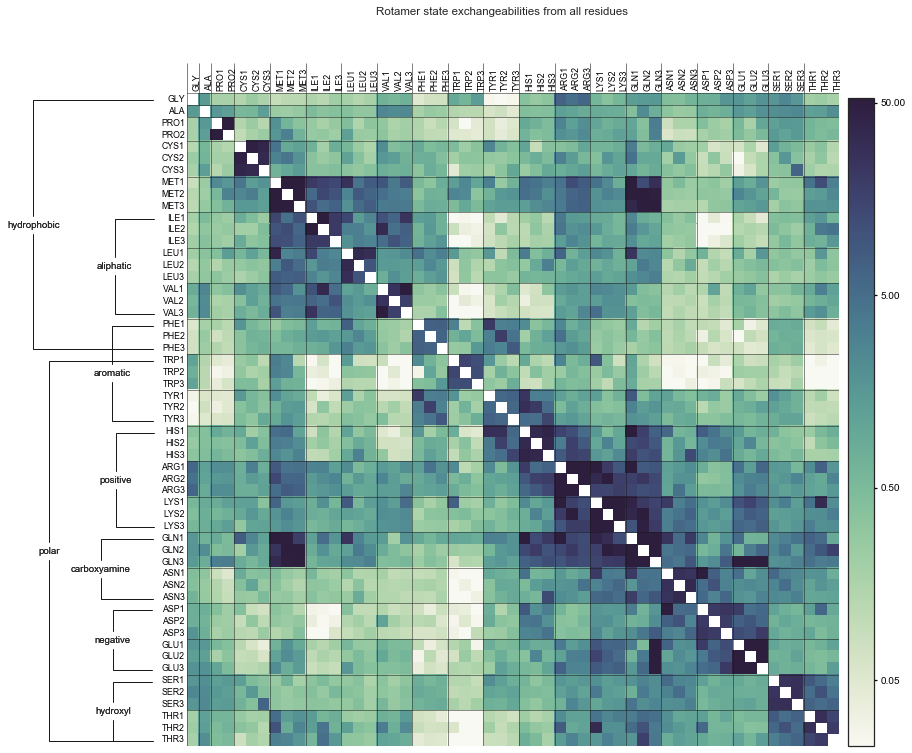

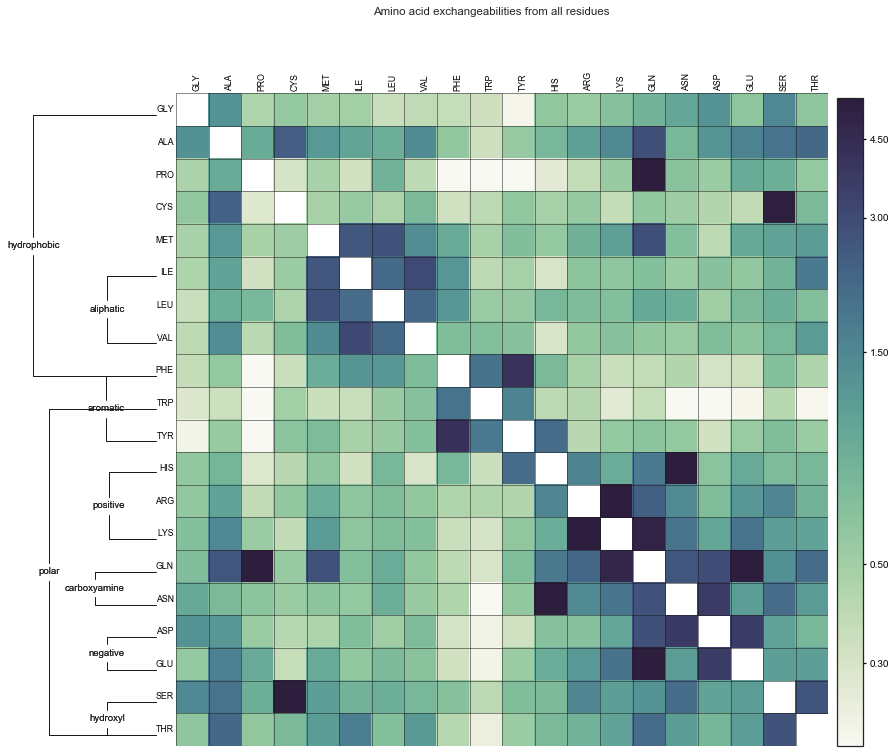

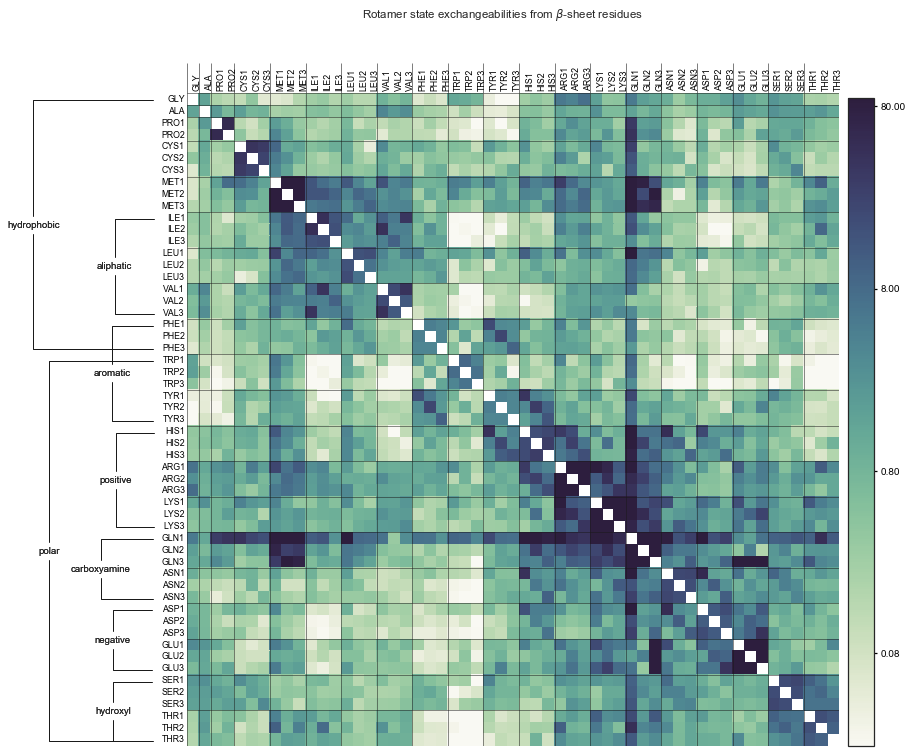

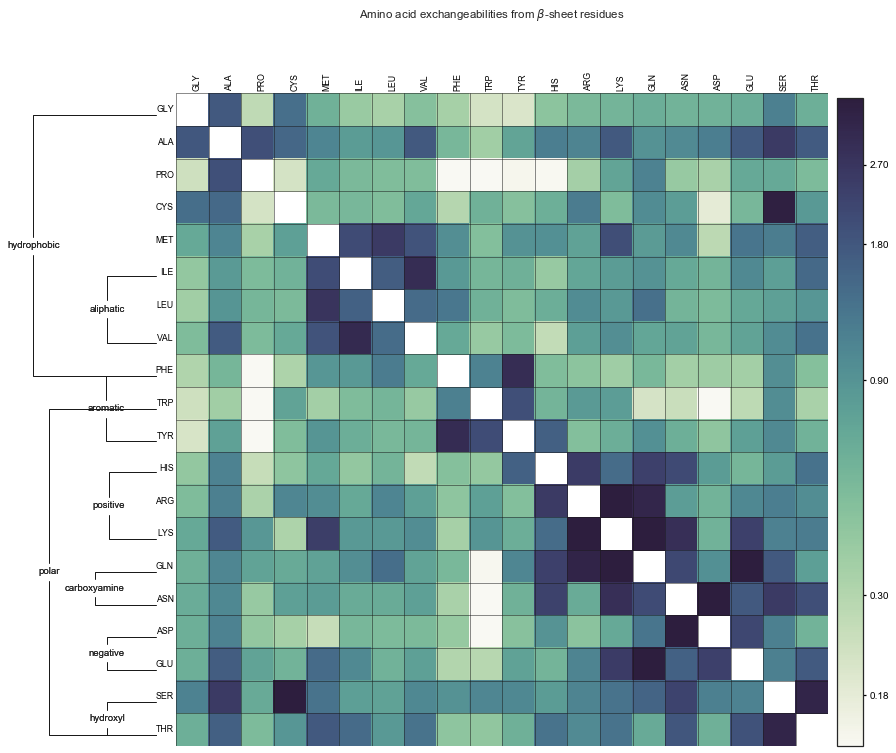

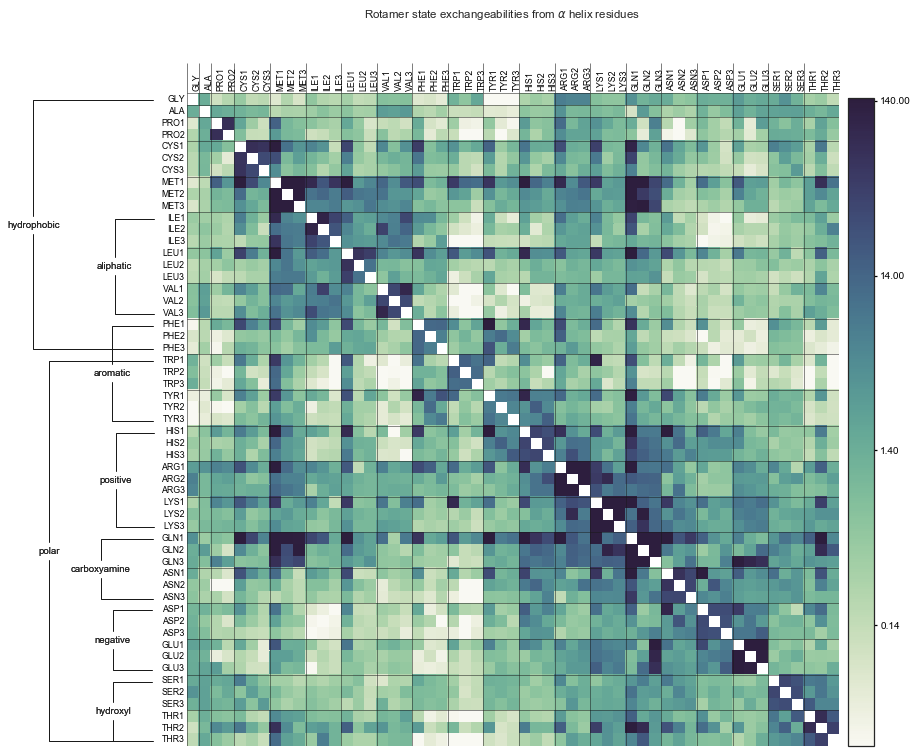

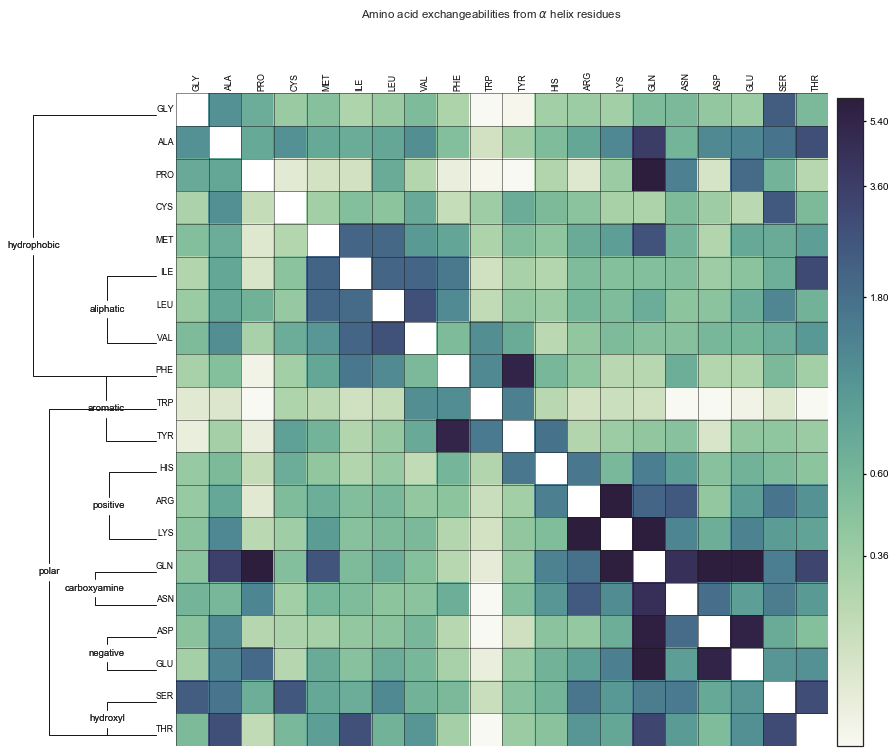

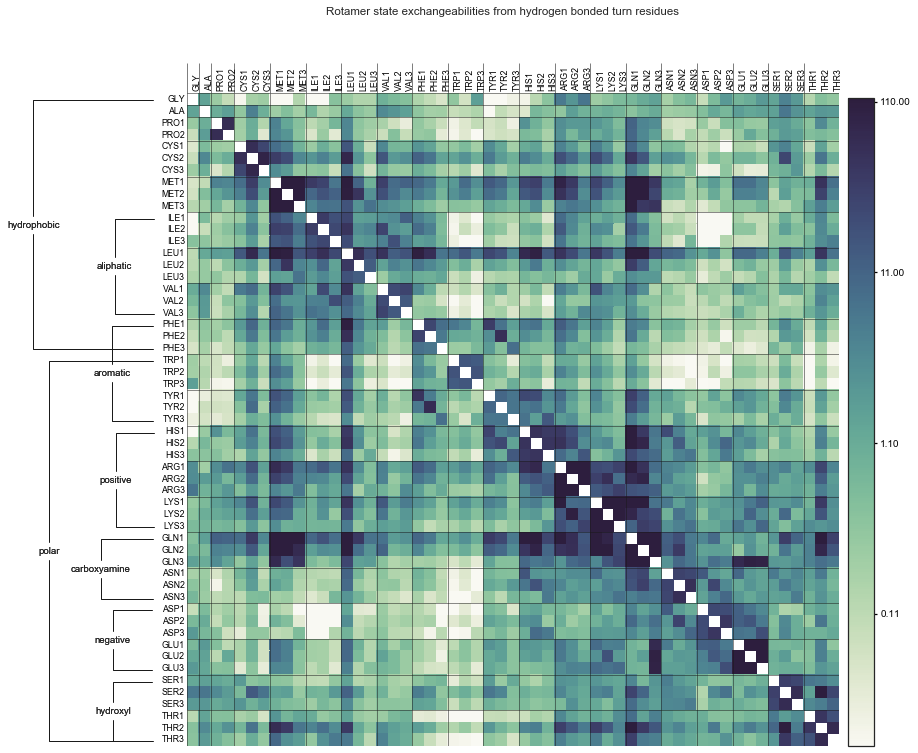

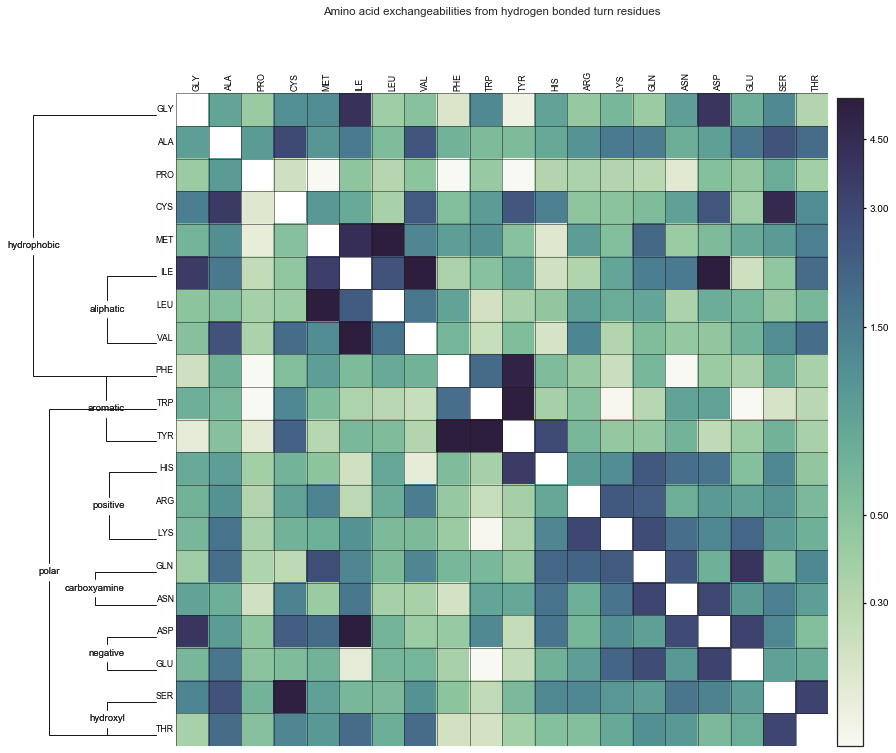

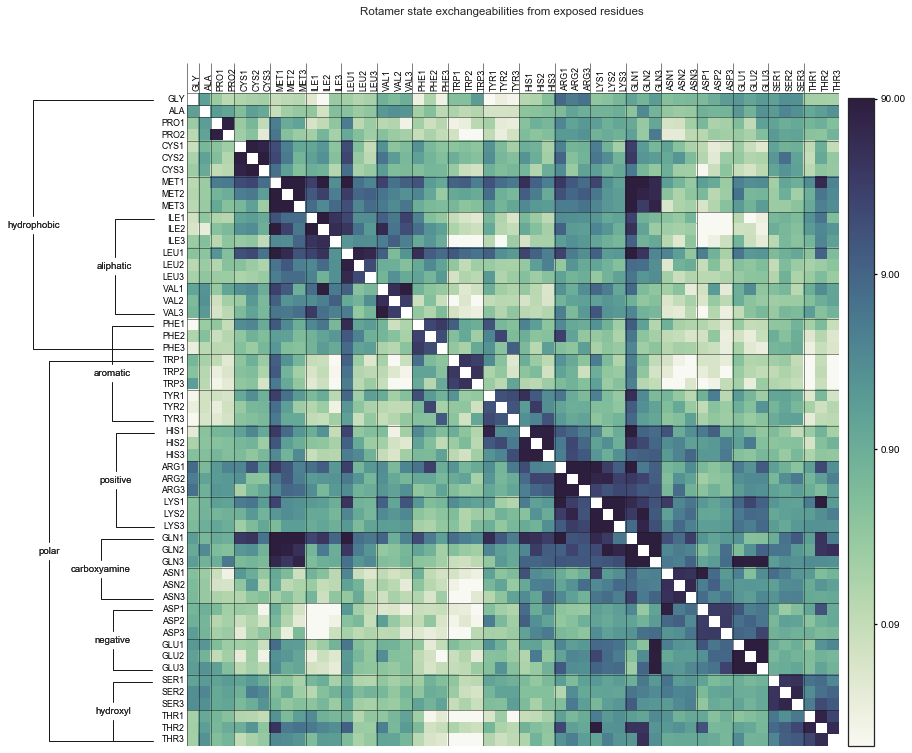

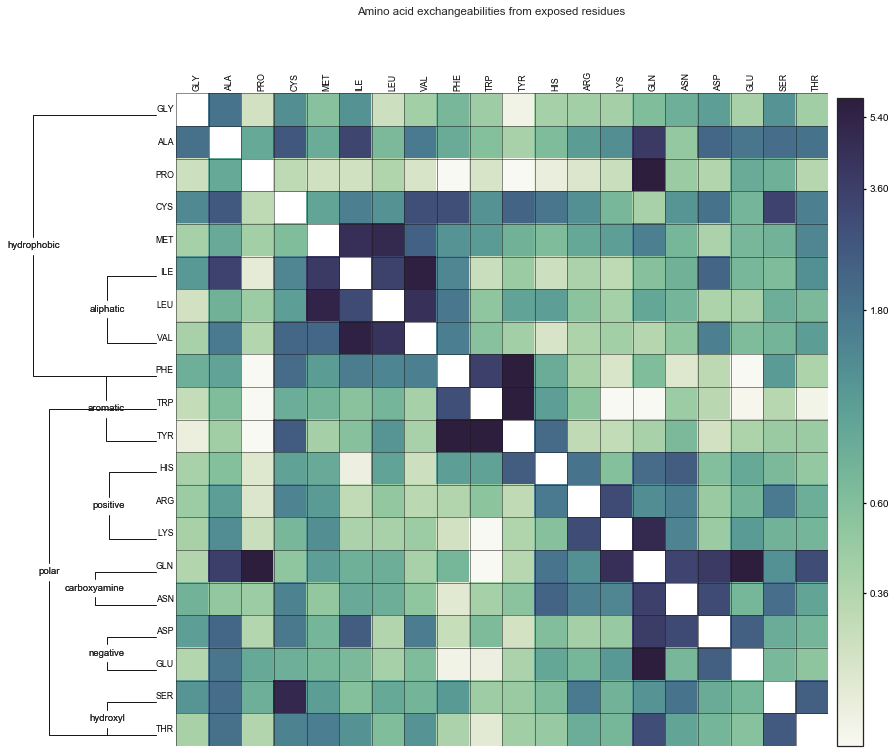

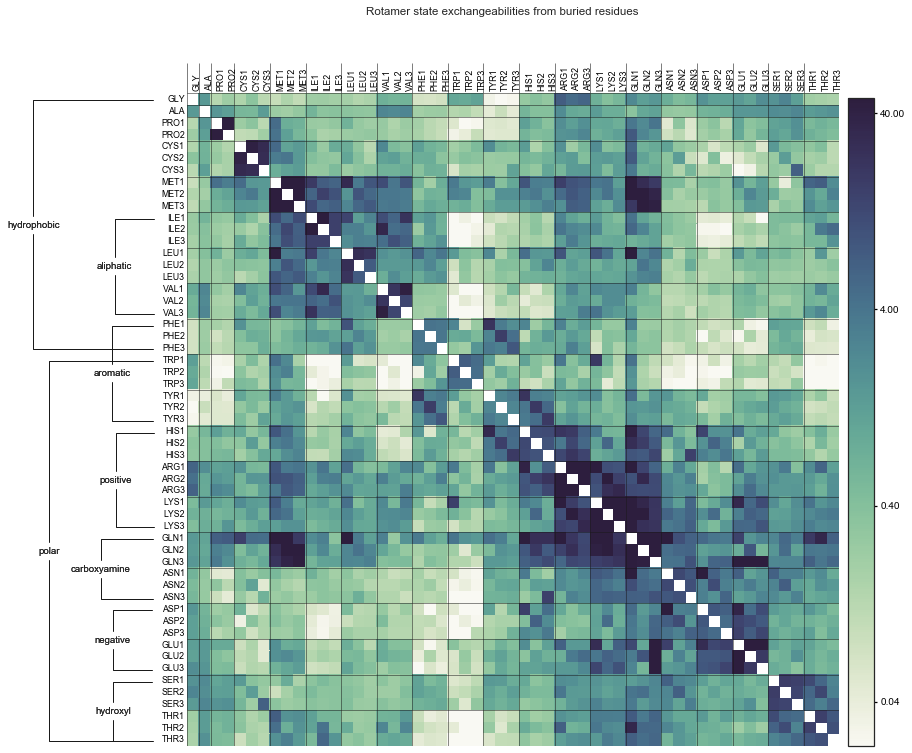

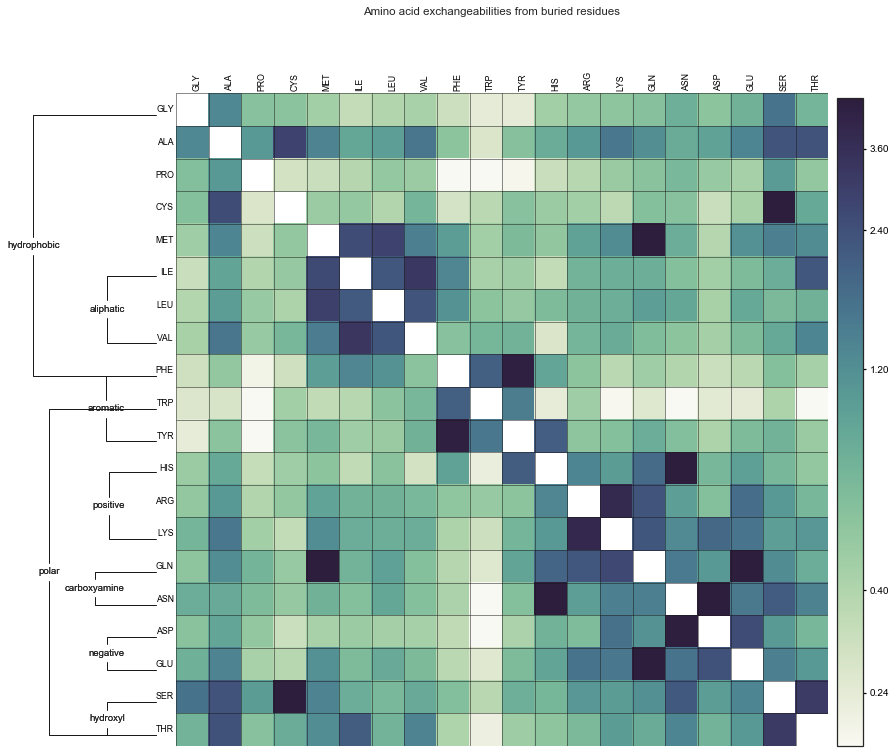

In [12]:
subset_names = ["all", r"$\beta$-sheet", r"$\alpha$ helix", "hydrogen bonded turn",
            "exposed", "buried"]
# path-friendly names
subset_file_labels = ["all", "b_sheet", "a_helix", "H_turn",
            "exposed", "buried"]

for label, file_label in zip(subset_names, subset_file_labels):
    path = f"data/{file_label}/RAM55annot_{file_label}_"
    ROTA_exch_file = f"{path}rota_Dnorm_exchang_superQ_f"
    AA_exch_file = f"{path}AA_exchang_Q_f"

    AA_exchang_df = pd.read_csv(AA_exch_file, sep="\t", header=0, index_col=0)
    rota_exchang_df = pd.read_csv(ROTA_exch_file, sep="\t", header=0, index_col=0)

    # plot the ROTA. heatmap
    fig, ax = plt.subplots(1, figsize=(12, 12))    
    plot_heatmap(ax, rota_exchang_df)
    fig.suptitle(f"Rotamer state exchangeabilities from {label} residues")
    fig.savefig(f"figures/RAM55annot_{file_label}_ROTA_exch_heatmap.pdf", format='pdf', 
            bbox_inches='tight', dpi=fig.dpi)

    # and the AA heatmap
    fig, ax = plt.subplots(1, figsize=(12, 12))    
    plot_heatmap(ax, AA_exchang_df)
    fig.suptitle(f"Amino acid exchangeabilities from {label} residues")
    fig.savefig(f"figures/RAM55annot_{file_label}_AA_exch_heatmap.pdf", format='pdf', 
            bbox_inches='tight', dpi=fig.dpi)

In [30]:
def plot_clustermap(exchang_df):
    # https://seaborn.pydata.org/generated/seaborn.clustermap.html
    # cluster rows and columns according to correlation distance
    # of their exchangeabilitis (log transformed, normalised

    exchang_df = exchang_df.replace(0.0, np.nan)
    cmap = sb.cubehelix_palette(start=.5, rot=-.7, light=.97, as_cmap=True)

    # label the clusters with colors
    # to see if they match with biochemical properties
    biochem_labels = ['hydrophobic',
                      'polar',
                      'carboxyamine',
                      'positive',
                      'hydroxyl',
                      'aliphatic',
                      'aromatic',
                      'negative']
    ROTA_lut_high = {}
    full_palette = sb.color_palette("husl", len(biochem_labels))
    for k, c in zip(biochem_labels[:2], full_palette[:2]):
        for rota in ROTA_dict_high[k]:
            ROTA_lut_high[rota] = c
    ROTA_lut_low = {}
    for k, c in zip(biochem_labels[2:], full_palette[2:]):
        for rota in ROTA_dict_low[k]:
            ROTA_lut_low[rota] = c
    labels = exchang_df.columns
    row_labels = pd.Series(labels, index=labels, name="")
    row_colors = row_labels.map(ROTA_lut_high)
    col_labels = pd.Series(labels, index=labels, name="")
    col_colors = col_labels.map(ROTA_lut_low)

    # log-transform exchangeabilities
    log_arr = np.log(exchang_df.values)
    log_arr = np.nan_to_num(log_arr, neginf=0.)
    # normalize rates
    norm_arr = log_arr / np.linalg.norm(log_arr, ord=1)

    plot_data = pd.DataFrame(norm_arr, index=labels, columns=labels)

    # mask diagonal
    mask = np.zeros(plot_data.shape, bool)
    np.fill_diagonal(mask, True)
    g = sb.clustermap(plot_data,
                      row_cluster=False,
                      col_cluster=True,
                      method="average",
                      mask=mask,
                      metric="correlation",
                      row_colors=row_colors,
                      col_colors=col_colors,
                      figsize=(12, 12),
                      cmap=cmap)
    fig = g.fig
    axes = fig.axes
    for ax in axes:
        ax.tick_params(axis='both', which='major', width=.0, pad=1.5)

    ax = axes[-2]
    ax.xaxis.tick_top()
    ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical', va="bottom")
    ax.yaxis.tick_left()
    ax.set_yticklabels(ax.get_yticklabels(), rotation='horizontal', ha="right")

    # create a custom legend handle for each series of boxplots
    patches = []
    for label, color in zip(biochem_labels, full_palette):
        patches.append(mpatches.Patch(color=color, label=label))
    ax.legend(handles=patches, loc=4, bbox_to_anchor=(1.2, 0.), frameon=False)

    return fig

/Users/uperron/anaconda3/envs/RAM55_annot_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


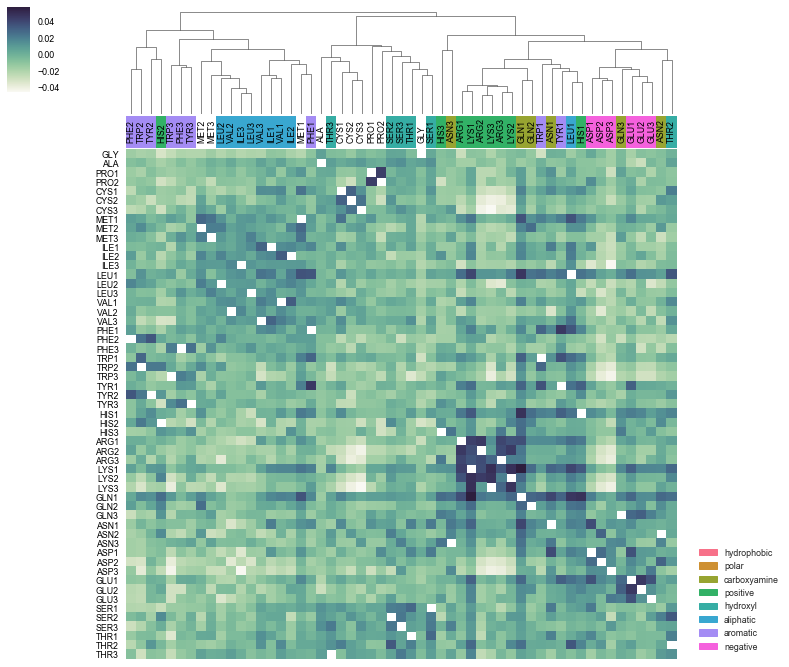

In [14]:
path = "data/HOMSTRAD_merged.ALLFAMS_accessibility_F.rota.exchangeabilities_superQ"
rota_exchang_df = pd.read_csv(path, sep="\t", header=0, index_col=0)
exchang_df = rota_exchang_df
#exchang_df = exchang_df.replace(0.0, np.nan)
cmap = sb.cubehelix_palette(start=.5, rot=-.7, light=.97, as_cmap=True)

# label the clusters with colors
# to see if they match with biochemical properties
biochem_labels = ['hydrophobic',
                  'polar',
                  'carboxyamine',
                  'positive',
                  'hydroxyl',
                  'aliphatic',
                  'aromatic',
                      'negative']
ROTA_lut_high = {}
full_palette = sb.color_palette("husl", len(biochem_labels))
for k, c in zip(biochem_labels[:2], full_palette[:2]):
    for rota in ROTA_dict_high[k]:
        ROTA_lut_high[rota] = c
ROTA_lut_low = {}
for k, c in zip(biochem_labels[2:], full_palette[2:]):
    for rota in ROTA_dict_low[k]:
        ROTA_lut_low[rota] = c
labels = exchang_df.columns
row_labels = pd.Series(labels, index=labels, name="")
row_colors = row_labels.map(ROTA_lut_high)
col_labels = pd.Series(labels, index=labels, name="")
col_colors = col_labels.map(ROTA_lut_low)

# log-transform exchangeabilities
log_arr = np.log(exchang_df.values)
log_arr = np.nan_to_num(log_arr, neginf=0.)
# normalize rates
norm_arr = log_arr / np.linalg.norm(log_arr, ord=1)

plot_data = pd.DataFrame(norm_arr, index=labels, columns=labels)

# mask diagonal
mask = np.zeros(plot_data.shape, bool)
np.fill_diagonal(mask, True)

g = sb.clustermap(plot_data,
                  row_cluster=False,
                  #col_cluster=True,
                  mask=mask,
                  metric="correlation",
                  #row_colors=row_colors,
                  col_colors=col_colors,
                  figsize=(12, 12),
                  cmap=cmap
                  )
fig = g.fig
axes = fig.axes
for ax in axes:
    ax.tick_params(axis='both', which='major', width=.0, pad=1.5)

ax = axes[-2]
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical', va="bottom")
ax.yaxis.tick_left()
ax.set_yticklabels(ax.get_yticklabels(), rotation='horizontal', ha="right")

# create a custom legend handle for each series of boxplots
patches = []
for label, color in zip(biochem_labels, full_palette):
    patches.append(mpatches.Patch(color=color, label=label))
ax.legend(handles=patches, loc=4, bbox_to_anchor=(1.2, 0.), frameon=False)
fig.savefig("figures/HOMSTRAD_buried_ROTA_exch_clustermap.pdf", format='pdf', 
            bbox_inches='tight', dpi=fig.dpi)

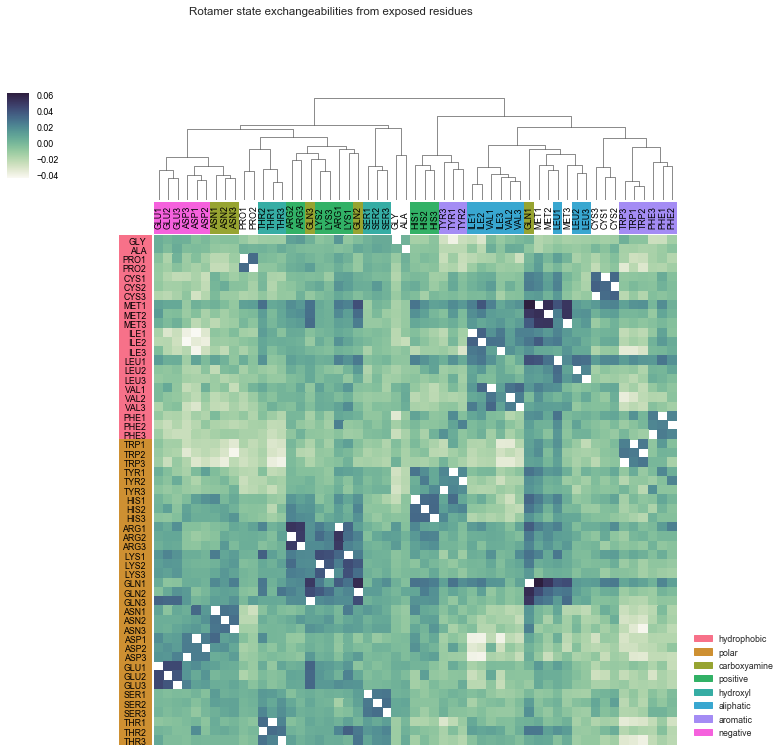

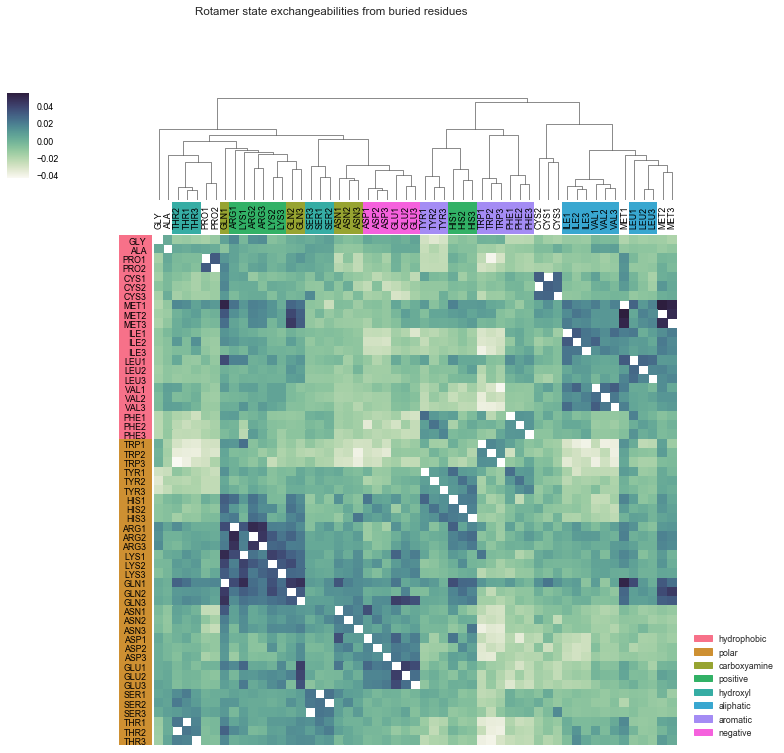

In [31]:
subset_names = ["exposed", "buried"]
# path-friendly names
subset_file_labels = ["exposed", "buried"]

for label, file_label in zip(subset_names, subset_file_labels):
    path = f"data/{file_label}/RAM55annot_{file_label}_"
    ROTA_exch_file = f"{path}rota_Dnorm_exchang_superQ_f"
    AA_exch_file = f"{path}AA_exchang_Q_f"

    AA_exchang_df = pd.read_csv(AA_exch_file, sep="\t", header=0, index_col=0)
    rota_exchang_df = pd.read_csv(ROTA_exch_file, sep="\t", header=0, index_col=0)

    # plot the ROTA clustermap   
    fig = plot_clustermap(rota_exchang_df)
    fig.suptitle(f"Rotamer state exchangeabilities from {label} residues")
    fig.savefig(f"figures/RAM55annot_{file_label}_ROTA_exch_clustermap.pdf", format='pdf', 
            bbox_inches='tight', dpi=fig.dpi)

In [115]:
# plot Cramer's V and diagonal ratio for each 3x3 submatrix
def plot_blockassoc(assoc_df):
    
    # filter on Bonferroni corrected P_val of the chi_squared test
    nozero_data = assoc_df[(assoc_df.Bonferroni_pval < .05)
                           # & (assoc_df.CramersV > .3)
                           ]

    # drop non-3x3 AA and all of those not in a first level group
    to_drop = ["ALA", "GLY", "PRO", "CYS", "MET"]
    square_data = nozero_data.query('a1 not in @to_drop & a2 not in @to_drop')

    # assign AA to groups, HIS is classified as positive
    AAdict = {'GLN': 'carboxyamine', 'HIS': 'positive', 'SER': 'hydroxyl',
              'VAL': 'aliphatic', 'LYS': 'positive', 'ILE': 'aliphatic', 
              'ASN': 'carboxyamine','THR': 'hydroxyl', 'PHE': 'aromatic', 
              'ALA': 'hydrophobic', 'ASP': 'negative', 'LEU': 'aliphatic', 
              'ARG': 'positive', 'TRP': 'aromatic', 'GLU': 'negative', 'TYR': 'aromatic'
              }

    # one color per residue pair (regardless of order)
    unique_groups = list(itertools.combinations_with_replacement(
        sorted(set(AAdict.values())), 2))
    
    def map_to_group(g_tup):
        if g_tup in unique_groups:
            return "-".join(g_tup)
        else:
            inv_tup = (g_tup[1], g_tup[0])
            return "-".join(inv_tup)
        
    nozero_data.loc[:, "group_name"] = np.vectorize(map_to_group)(pd.Series(zip(
        nozero_data['a1'].map(AAdict).astype(str), nozero_data['a2'].map(AAdict).astype(str))))

    to_keep = ['aromatic-aromatic', 'negative-negative', 'positive-positive',
               'aromatic-positive', 'aliphatic-aromatic',
               'negative-positive', 'aromatic-carboxyamine', 'carboxyamine-positive',
               'aliphatic-positive', 'aromatic-negative',
               'hydroxyl-positive', 'aromatic-hydroxyl']

    nozero_data = nozero_data.query('group_name in @to_keep')

    # label polar and hydrophobic residue pairs
    hydrophobic_aa = ["CYS", "MET", "ILE", "LEU", "VAL", "PHE"]
    arr = []
    for a1, a2 in nozero_data[["a1", "a2"]].values:
        if a1 in hydrophobic_aa and a2 in hydrophobic_aa:
            v = "Both hydrophobic"
        elif a1 not in hydrophobic_aa and a2 not in hydrophobic_aa:
            v = "Both polar"
        else:
            v = "Mixed"
        arr.append(v)
    nozero_data["hydro"] = arr

    # convert AA names to one letter codes for annotation
    three_one_dict = dict(
        zip("ALA,ARG,ASN,ASP,CYS,GLN,GLU,GLY,HIS,ILE,LEU,LYS,MET,PHE,PRO,SER,THR,TRP,TYR,VAL".split(","),
            "A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V".split(",")))
    nozero_data.loc[:, "sl1"] = nozero_data['a1'].map(three_one_dict)
    nozero_data.loc[:, "sl2"] = nozero_data['a2'].map(three_one_dict)

    # one marker per AA1 - AA2 combination
    colors = sb.color_palette("colorblind", 6, desat=.9)
    l = list(itertools.combinations_with_replacement(
        sorted(set(AAdict.values())), 2))
    s = list(itertools.product(colors, ["^", "v", "o", "D", "X", "<"]))

    sym_dict = dict(zip(l, s))

    def map_to_symbol(g_tup):
        if g_tup in sym_dict:
            return sym_dict[g_tup]
        else:
            inv_tup = (g_tup[1], g_tup[0])
            return sym_dict[inv_tup]


    L = list(zip(nozero_data['a1'].map(AAdict).astype(
        str), nozero_data['a2'].map(AAdict).astype(str)))
    nozero_data["symbol"] = [map_to_symbol(l)[1] for l in L]

    # sort groups by median diag ratio
    nozero_data.loc[:, 'group_median'] = nozero_data.groupby(
        'group_name')['diagonal_ratio'].transform(np.median)
    nozero_data.sort_values(['group_median'], ascending=[True], inplace=True)

    # plot the CramerV / diagratio scatterplot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 18)) # 1 col, 2 rows
    sb.scatterplot(x='CramersV', y='diagonal_ratio', 
                   hue="group_name", style="hydro", s=80,
                   data=nozero_data, ax=ax1)
    # annotate datapoints with residue pair labels
    for label, x_val, y_val in zip(nozero_data["sl1"] + "," + nozero_data["sl2"],
                                   nozero_data['CramersV'].tolist(), nozero_data['diagonal_ratio'].tolist()):
        ax1.annotate(label, xy=(x_val, y_val), xytext=(15, -15), textcoords='offset points',
                     ha='right', va='bottom', fontsize='medium', arrowprops=dict(arrowstyle='-',
                                                                                 connectionstyle='arc3,rad=0'))
    ax1.set_xlabel('Cramer\'s V', fontsize='large')
    ax1.set_ylabel('Diagonal ratio', fontsize='large')

    # remove small groups (size <3)
    groups = nozero_data.groupby('group_name', sort=False)
    groups = groups.filter(lambda x: len(x) > 3).groupby('group_name', sort=False)
    nozero_data = nozero_data[nozero_data.group_name.isin(
        [name for name, group in groups])]
    
    # plot the diagratio by groups boxplot
    g = sb.catplot(x="group_name", y="diagonal_ratio", kind="box",
                   color="w",
                   data=nozero_data, ax=ax2)
    # since group size is small overlay swarm
    s = sb.catplot(x="group_name", y="diagonal_ratio", kind="swarm",
                   hue="group_name", s=8,
                   data=nozero_data, ax=ax2)
    # map all datapoints in group to location for annotating
    coord_dict = dict(zip(nozero_data.group_name.unique(),ax2.get_xticks()))
    nozero_data["group_x"] = nozero_data.group_name.map(coord_dict)
    # annotate swarm with residue pair label
    for label, x_val, y_val in zip(nozero_data["sl1"] + "," + nozero_data["sl2"],
                                   nozero_data.group_x.tolist(), nozero_data.diagonal_ratio.tolist()):
        ax2.annotate(label, xy=(x_val, y_val), xytext=(15, -15), textcoords='offset points',
                     ha='right', va='bottom', fontsize='medium', arrowprops=dict(arrowstyle='-',
                                                                                 connectionstyle='arc3,rad=0'))
    ax2.set_ylabel('Diagonal ratio', fontsize='large')
    ax2.set_xlabel("", fontsize='large')
    ax2.tick_params(axis='both', length=3)
    ax2.set_xticklabels(ax.get_xticklabels(), rotation=30,
                        fontsize='medium', ha='right')
    return fig

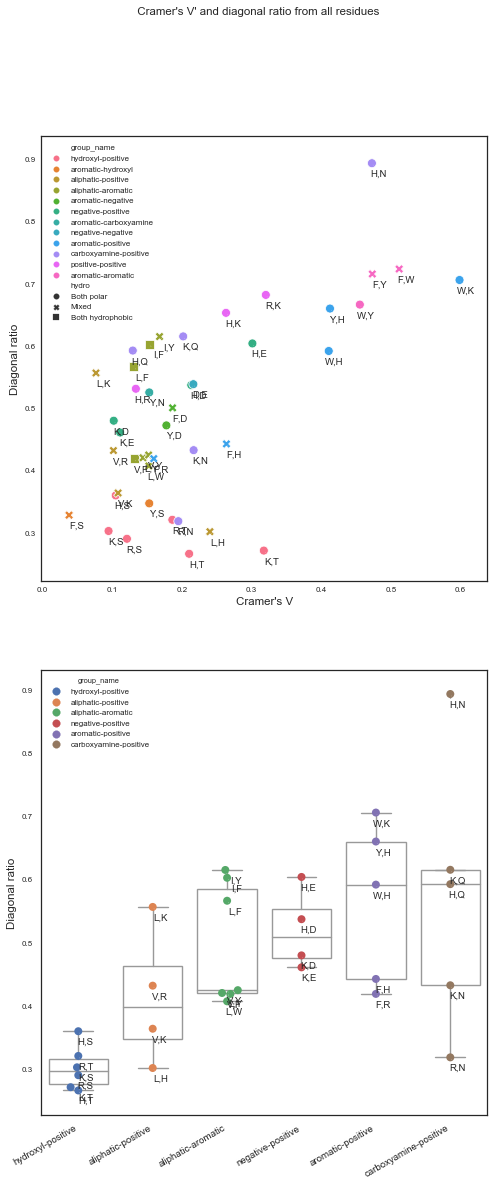

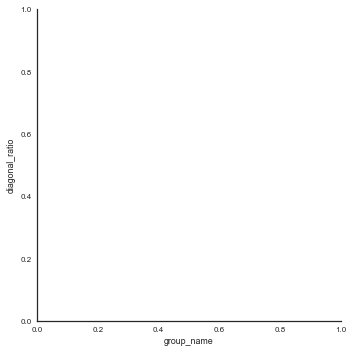

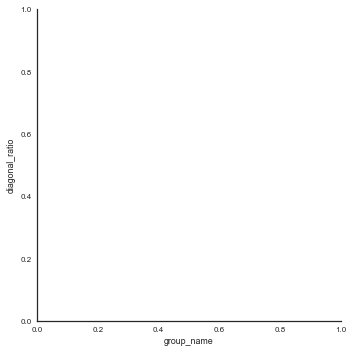

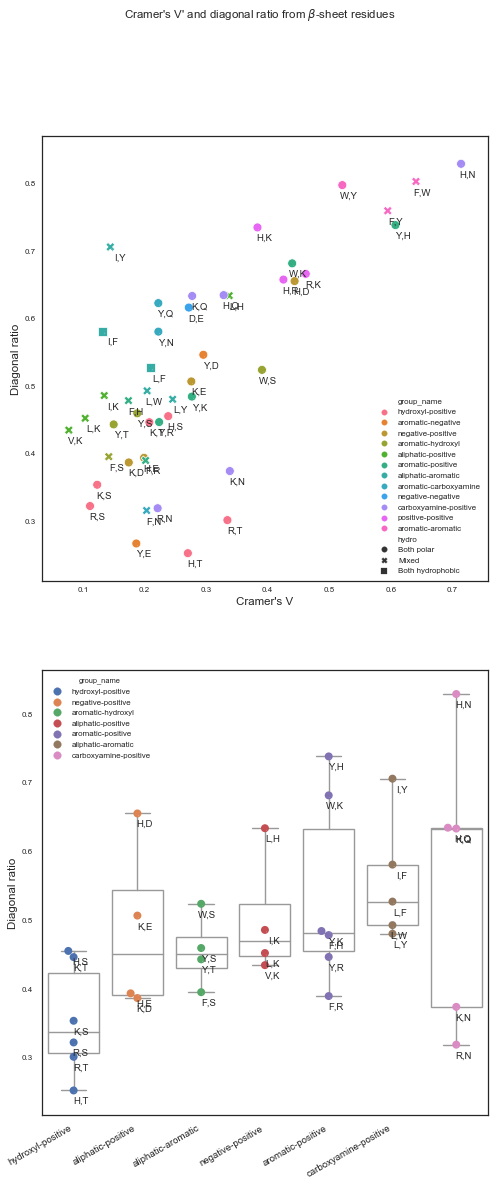

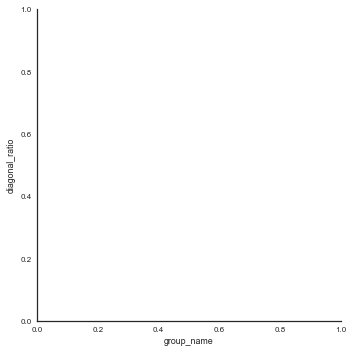

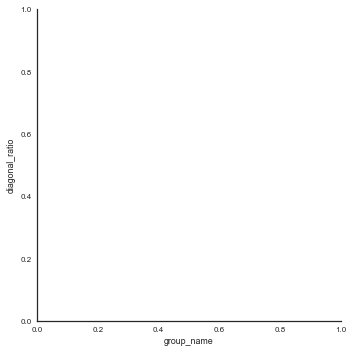

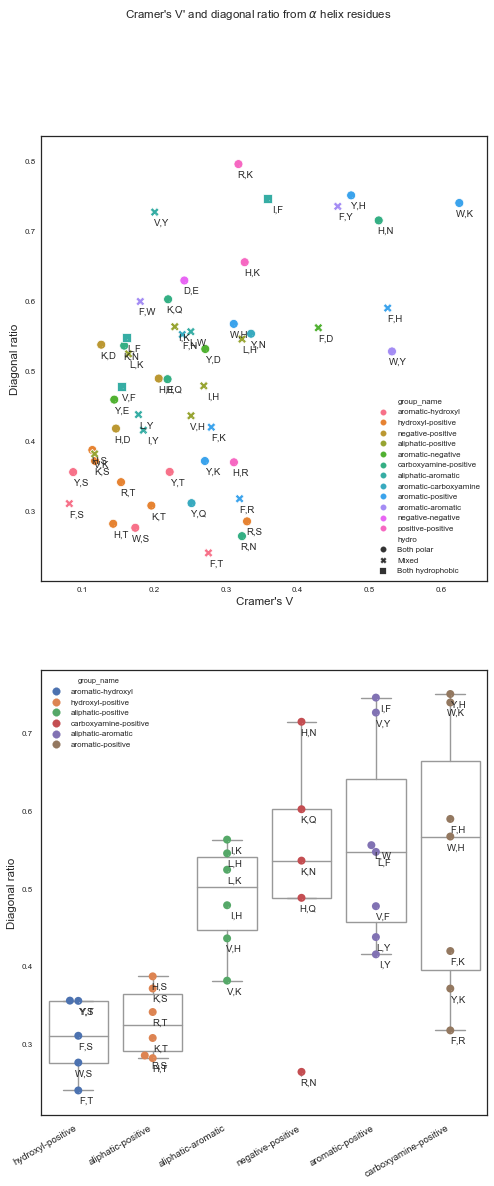

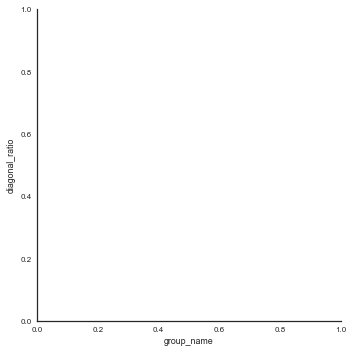

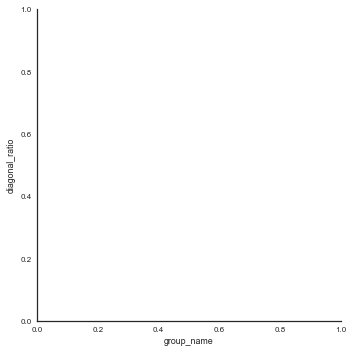

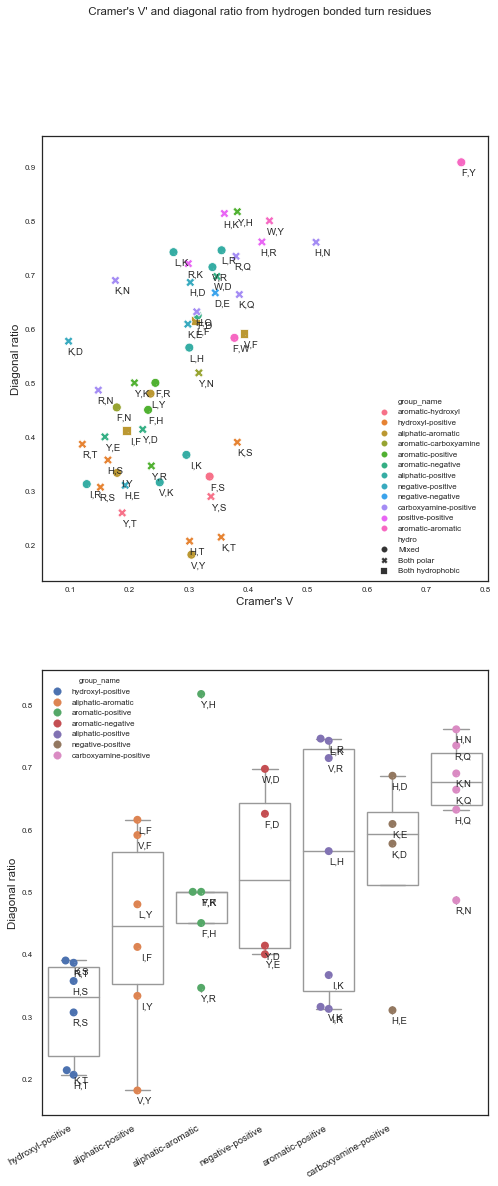

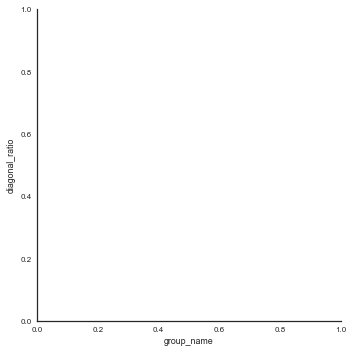

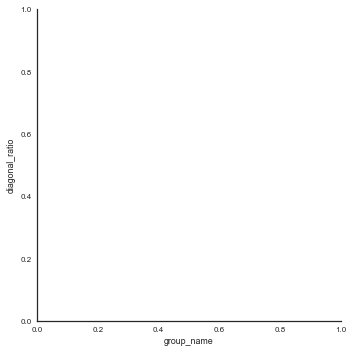

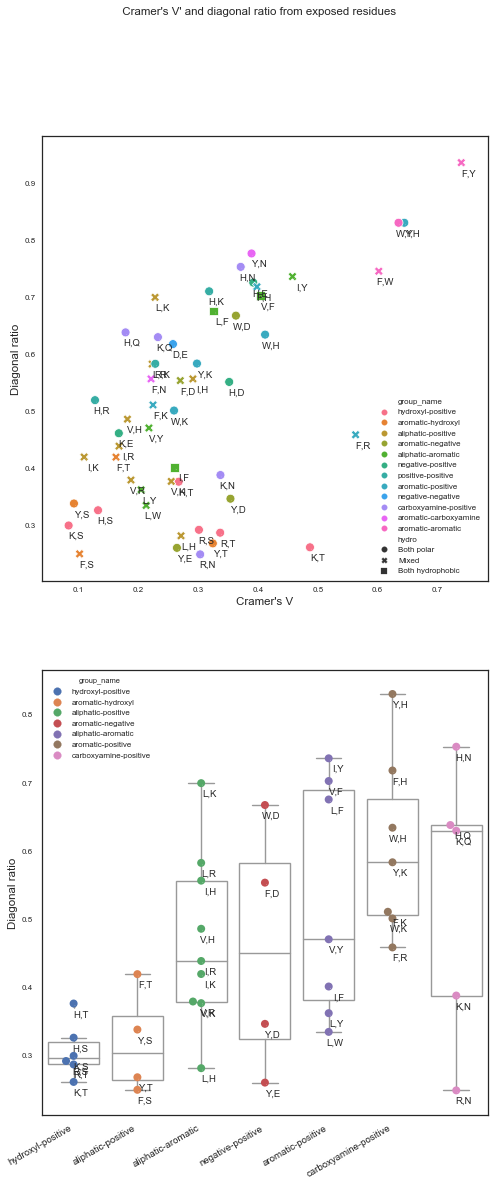

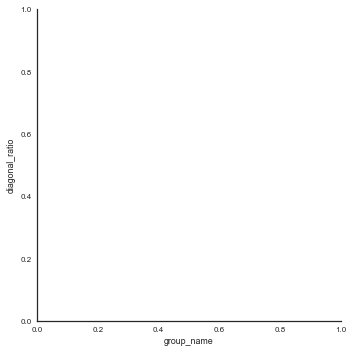

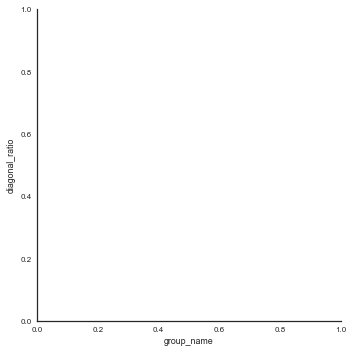

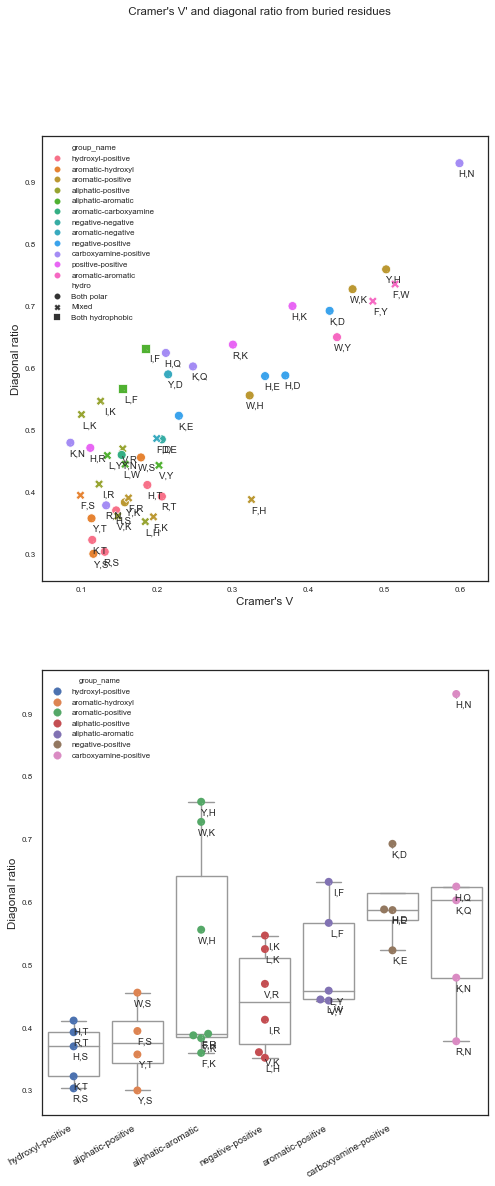

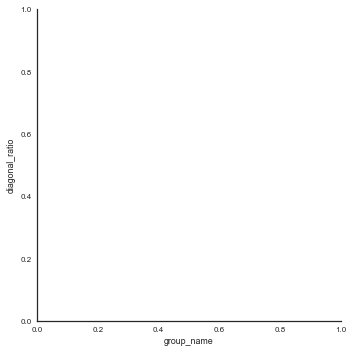

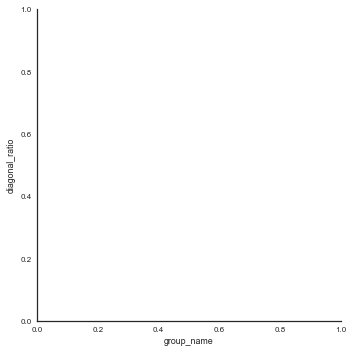

In [113]:
subset_names = ["all", r"$\beta$-sheet", r"$\alpha$ helix", "hydrogen bonded turn",
            "exposed", "buried"]
# path-friendly names
subset_file_labels = ["all", "b_sheet", "a_helix", "H_turn",
            "exposed", "buried"]

for label, file_label in zip(subset_names, subset_file_labels):
    path = f"data/{file_label}/RAM55annot_{file_label}_"
    block_assoc_file = f"{path}bloc_association.tab"
    assoc_df = pd.read_csv(block_assoc_file, sep="\t", header=0)
    fig = plot_blockassoc(assoc_df)
    fig.suptitle(f" Cramer\'s V' and diagonal ratio from {label} residues")
    fig.savefig(f"figures/RAM55annot_{file_label}_CramerV_diagratio.pdf", format='pdf', 
            bbox_inches='tight', dpi=fig.dpi)

In [174]:
subset_names = ["all", r"$\beta$-sheet", r"$\alpha$ helix", "hydrogen bonded turn",
                "exposed", "buried"]
# path-friendly names
subset_file_labels = ["all", "b_sheet", "a_helix", "H_turn",
                      "exposed", "buried"]
# read all matrices
all_matrix_arr = []
all_matrix_labels = []
for label, file_label in zip(subset_names, subset_file_labels):
    path = f"data/{file_label}/RAM55annot_{file_label}_"
    ROTA_exch_file = f"{path}rota_Dnorm_exchang_superQ_f"
    AA_exch_file = f"{path}AA_exchang_Q_f"
    rota_exchang_df = pd.read_csv(
        ROTA_exch_file, sep="\t", header=0, index_col=0)
    all_matrix_arr.append(rota_exchang_df.values)
    all_matrix_labels.append(file_label)
arr = []
for matrix_1, label_1 in zip(all_matrix_arr, all_matrix_labels):
    for matrix_2, label_2 in zip(all_matrix_arr, all_matrix_labels):
        # calculate Bray-Curtis distance between pair of matrices
        # https://docs.scipy.org/doc/scipy/reference/generated/\
        # scipy.spatial.distance.braycurtis.html#scipy.spatial.distance.braycurtis
        arr.append([label_1, label_2, scipy.spatial.distance.braycurtis(
            matrix_1.flatten(), matrix_2.flatten())])
matrix_corr_df = pd.DataFrame(arr, columns=["l1", "l2", "braycurtis"])
matrix_corr_df =matrix_corr_df.sort_values(by="braycurtis", ascending=False)
matrix_corr_df[matrix_corr_df.braycurtis >.0]

l1       l2  braycurtis
29  exposed   buried    0.552598
34   buried  exposed    0.552598
17  a_helix   buried    0.525214
32   buried  a_helix    0.525214
23   H_turn   buried    0.489008
33   buried   H_turn    0.489008
8   b_sheet  a_helix    0.388822
13  a_helix  b_sheet    0.388822
2       all  a_helix    0.387014
12  a_helix      all    0.387014
25  exposed  b_sheet    0.381260
10  b_sheet  exposed    0.381260
4       all  exposed    0.365470
24  exposed      all    0.365470
20   H_turn  a_helix    0.351978
15  a_helix   H_turn    0.351978
3       all   H_turn    0.350483
18   H_turn      all    0.350483
1       all  b_sheet    0.343215
6   b_sheet      all    0.343215
19   H_turn  b_sheet    0.337279
9   b_sheet   H_turn    0.337279
11  b_sheet   buried    0.326106
31   buried  b_sheet    0.326106
22   H_turn  exposed    0.289084
27  exposed   H_turn    0.289084
30   buried      all    0.276072
5       all   buried    0.276072
16  a_helix  exposed    0.232741
26  exposed  a_helix    0.232741

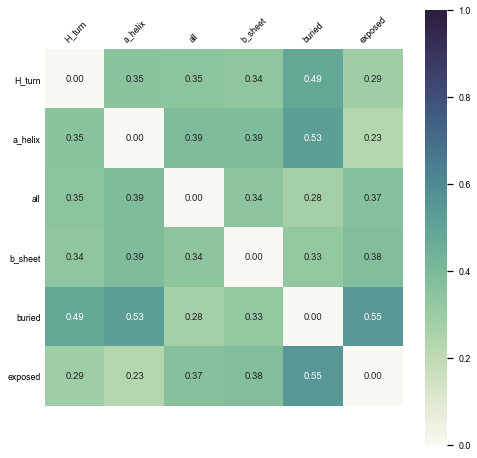

In [175]:
# tab to matrix
matrix_corr_df = matrix_corr_df.set_index(["l1", "l2"]).unstack()
index = matrix_corr_df.index.tolist()
matrix_corr_df.columns = index
matrix_corr_df.index = index

fig, ax = plt.subplots(figsize=(8, 8))
cmap = sb.cubehelix_palette(start=.5, rot=-.7, light=.97, as_cmap=True)

ax = sb.heatmap(
    matrix_corr_df,
    vmin=0, vmax=1, center=.5,
    cmap=cmap,
    square=True,
    annot=True, fmt=".2f")
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    ha='center'
);
ax.xaxis.tick_top()
ax.tick_params(axis='both', which='major', length=.0, pad=5)
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation="horizontal",
    horizontalalignment='right'
);

fig.savefig(f"figures/RAM55annot_allmatrices_braycurtis_heatmap.pdf", format='pdf', 
            bbox_inches='tight', dpi=fig.dpi)

"all" is close to every matrix. "buried" and "exposed" are the most distant, followed by "buried" - "a-helix", and "buried" - "h-turn""

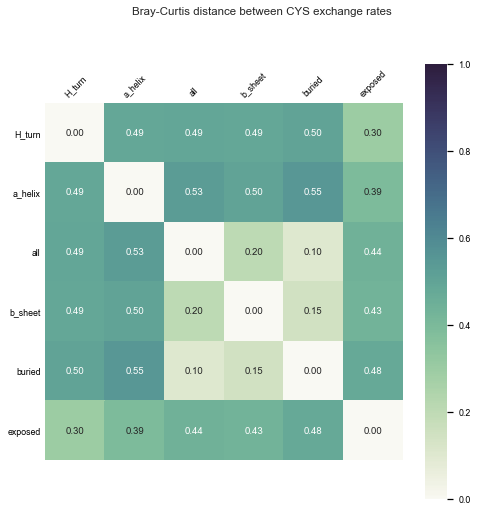

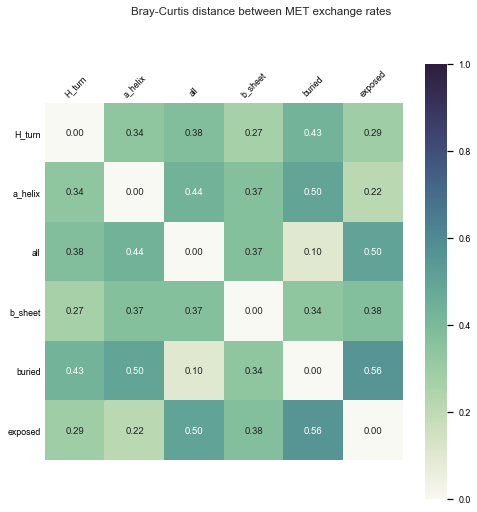

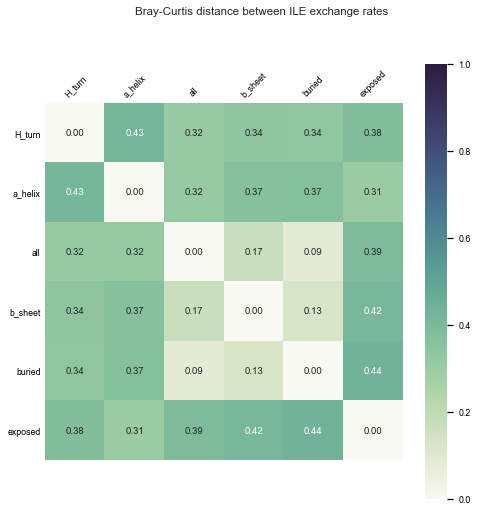

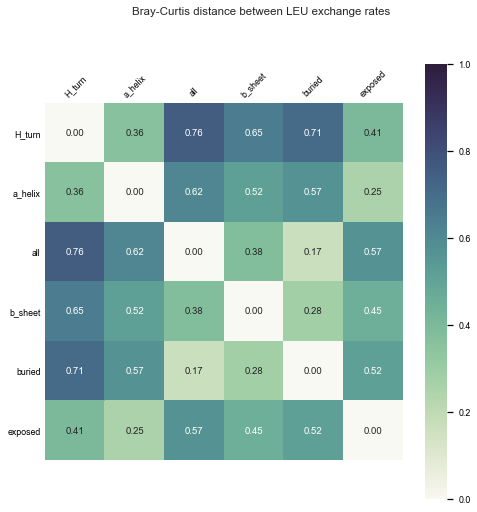

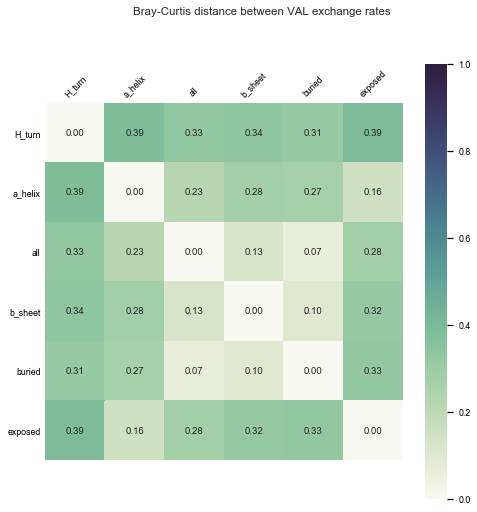

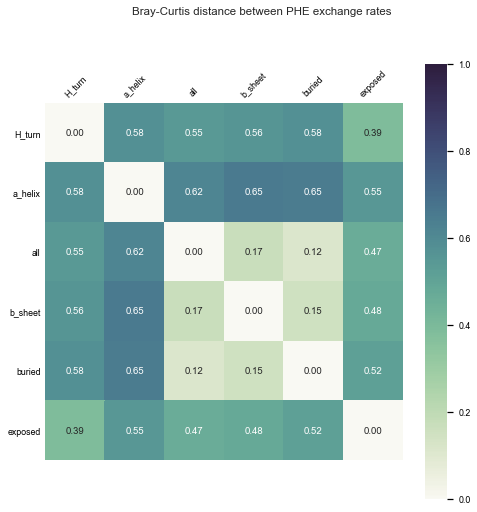

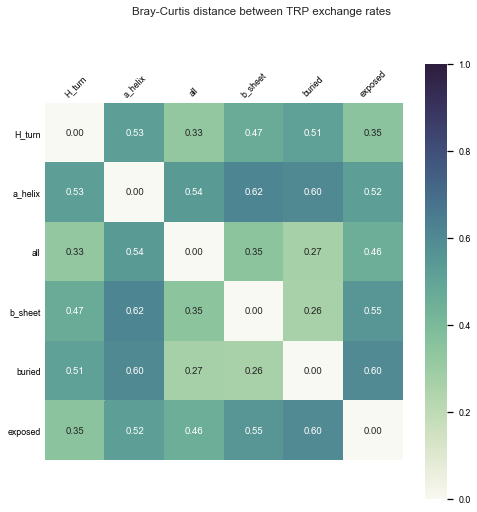

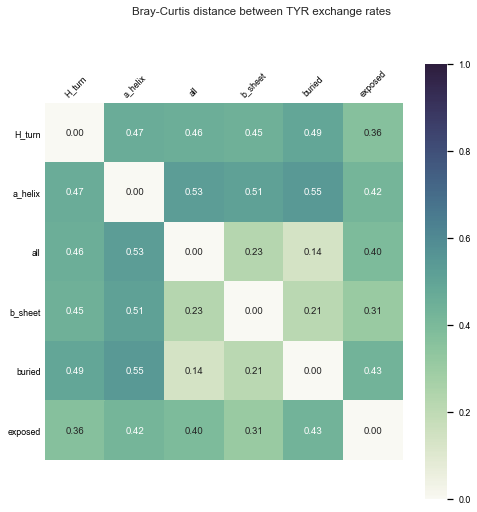

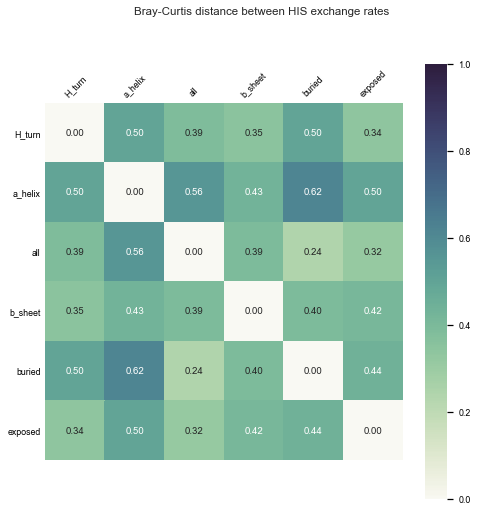

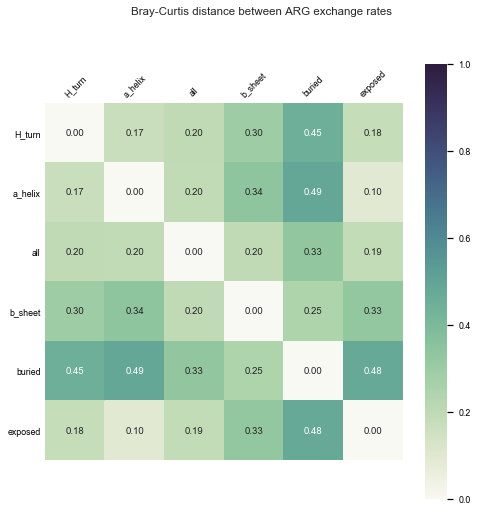

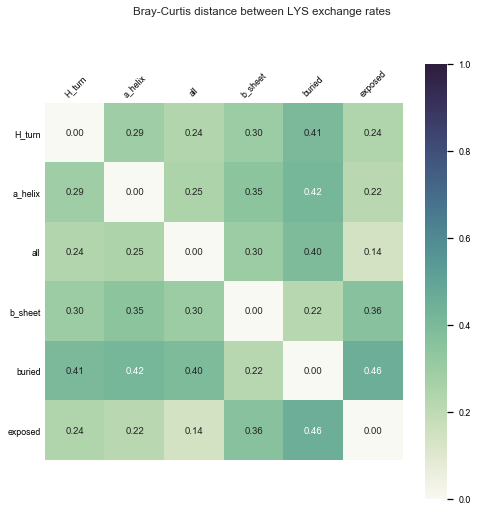

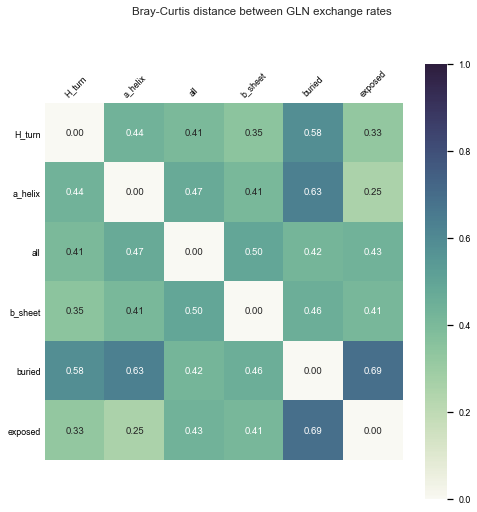

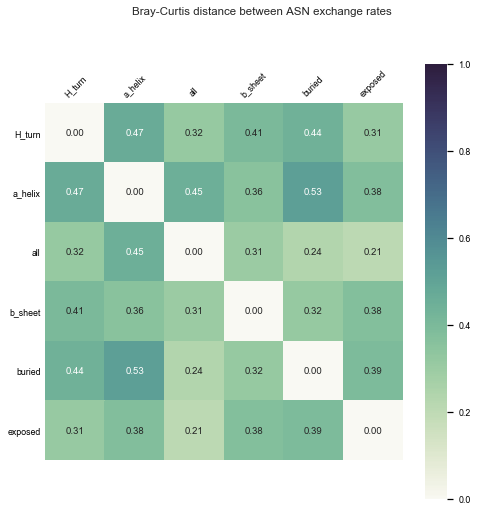

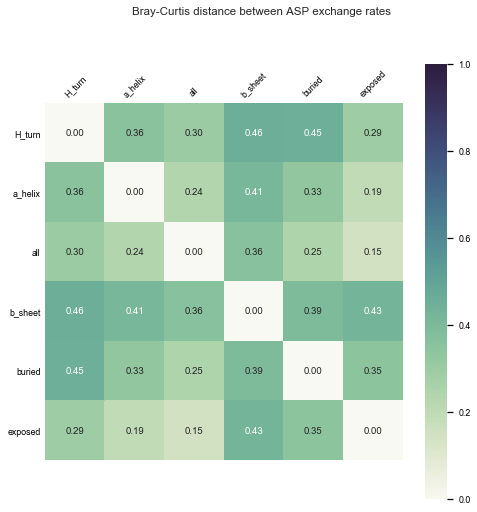

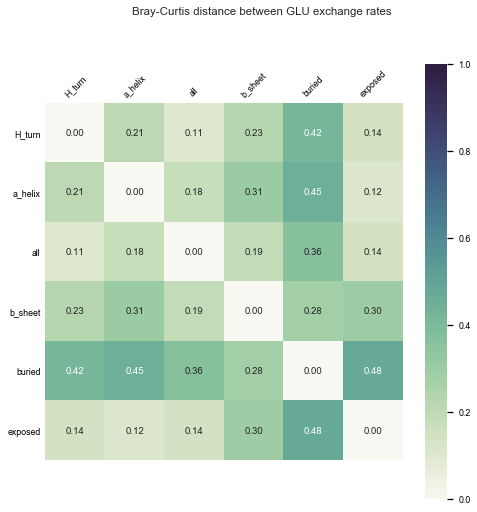

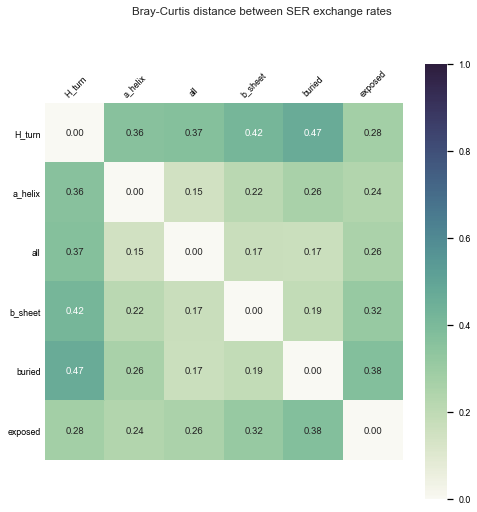

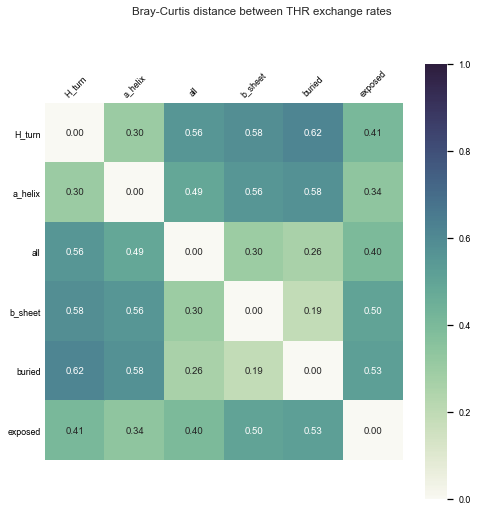

In [178]:
selected_AA = ['CYS', 'MET', 'ILE', 'LEU', 'VAL', 'PHE', 'TRP', 'TYR',
               'HIS', 'ARG', 'LYS', 'GLN', 'ASN', 'ASP', 'GLU', 'SER', 'THR']

# simple matrix dot product to get distance matrix
all_matrix_arr = []
all_matrix_labels = []
for label, file_label in zip(subset_names, subset_file_labels):
    path = f"data/{file_label}/RAM55annot_{file_label}_"
    ROTA_exch_file = f"{path}rota_Dnorm_exchang_superQ_f"
    AA_exch_file = f"{path}AA_exchang_Q_f"
    rota_exchang_df = pd.read_csv(
        ROTA_exch_file, sep="\t", header=0, index_col=0)
    all_matrix_arr.append(rota_exchang_df)
    all_matrix_labels.append(file_label)

cmap = sb.cubehelix_palette(start=.5, rot=-.7, light=.97, as_cmap=True)

dist_arr = []
for aa in selected_AA:
    ROTAs = [aa + n for n in ("1", "2", "3")]
    arr = []
    for matrix_1, label_1 in zip(all_matrix_arr, all_matrix_labels):
        for matrix_2, label_2 in zip(all_matrix_arr, all_matrix_labels):
            # slice the corresponding rotamer submatrix
            row_1 = matrix_1.loc[ROTAs, :].values.flatten()
            row_2 = matrix_2.loc[ROTAs, :].values.flatten()
            block_braycurtis = scipy.spatial.distance.braycurtis(row_1, row_2)
            arr.append([label_1, label_2, block_braycurtis])
    matrix_corr_df = pd.DataFrame(arr, columns=["l1", "l2", "braycurtis"])
    dist_arr.append([aa, matrix_corr_df.braycurtis.sum()])
    # tab to matrix
    matrix_corr_df = matrix_corr_df.set_index(["l1", "l2"]).unstack()
    index = matrix_corr_df.index.tolist()
    matrix_corr_df.columns = index
    matrix_corr_df.index = index
    
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # plot correlation heatmap
    sb.heatmap(
        matrix_corr_df,
        vmin=0, vmax=1, center=.5,
        cmap=cmap,
        annot=True, fmt=".2f",
        square=True, ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       ha='center')

    ax.xaxis.tick_top()
    ax.tick_params(axis='both', which='major', length=.0, pad=5)

    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation="horizontal",
        horizontalalignment='right')
    fig.suptitle(f"Bray-Curtis distance between {aa} exchange rates")
    fig.savefig(f"figures/RAM55annot_{aa}matrices_braycurtis_heatmap.pdf", format='pdf', 
            bbox_inches='tight', dpi=fig.dpi)
braycurtis_df = pd.DataFrame(dist_arr, columns=["aa", "braycurtis"])

In [182]:
braycurtis_df.sort_values(by="braycurtis", ascending=False).head()

aa  braycurtis
3   LEU   14.410340
5   PHE   14.087317
6   TRP   13.958346
11  GLN   13.583085
16  THR   13.226292

I decide to investigate 5 comparison in further detail:
helix / sheet and exposed/buried for TRP;
helix / sheet for PHE;
all / turn for LEU
buried / exposed for GLN
        

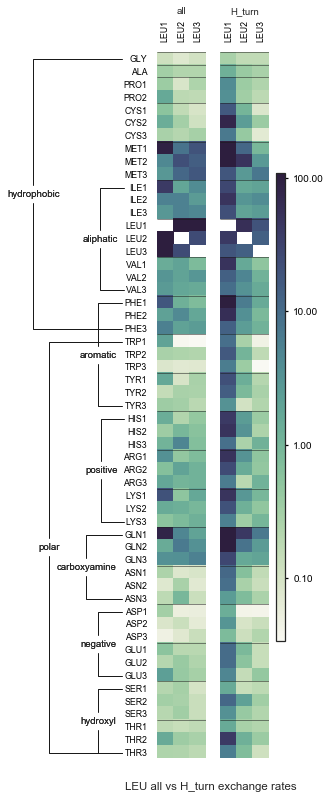

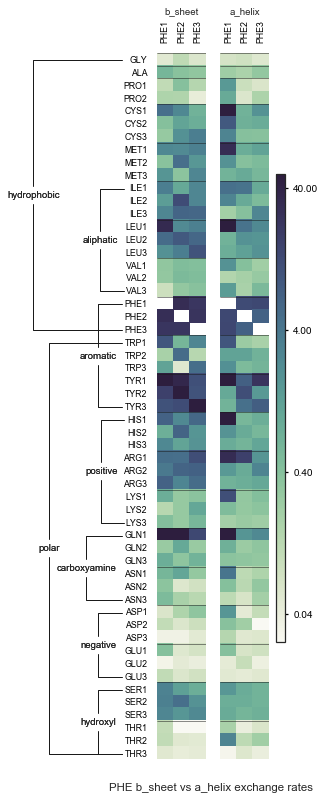

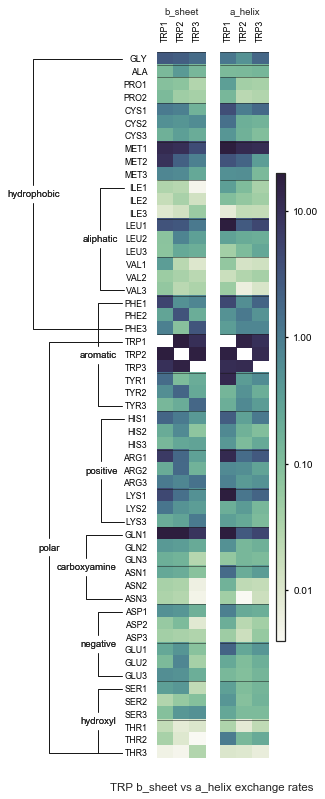

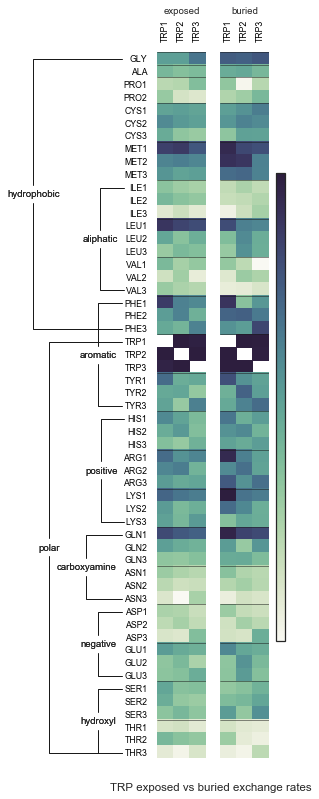

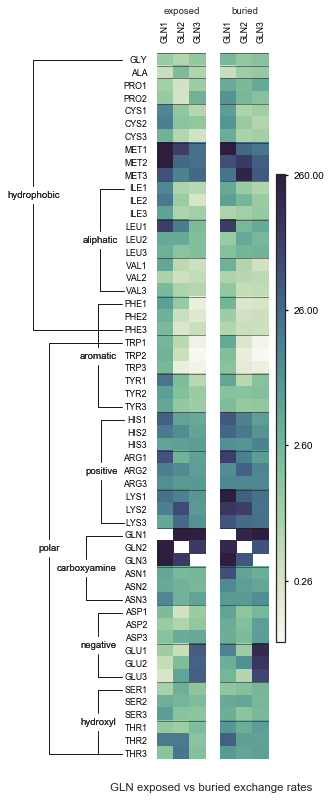

In [250]:
selected_AA = ["LEU", "PHE", "TRP", "TRP", "GLN"]
pairs = [("all", "H_turn"), ("b_sheet", "a_helix"), ("b_sheet", "a_helix"), ("exposed", "buried"),
         ("exposed", "buried")]

all_matrix_arr = []
all_matrix_labels = []
for label, file_label in zip(subset_names, subset_file_labels):
    path = f"data/{file_label}/RAM55annot_{file_label}_"
    ROTA_exch_file = f"{path}rota_Dnorm_exchang_superQ_f"
    AA_exch_file = f"{path}AA_exchang_Q_f"
    rota_exchang_df = pd.read_csv(
        ROTA_exch_file, sep="\t", header=0, index_col=0)
    all_matrix_arr.append(rota_exchang_df)
    all_matrix_labels.append(file_label)

matrix_dict = dict(zip(all_matrix_labels, all_matrix_arr))
cmap = sb.cubehelix_palette(start=.5, rot=-.7, light=.97, as_cmap=True)

dist_arr = []
for aa, labels in zip(selected_AA, pairs):
    label_1, label_2 = labels
    ROTAs = [aa + n for n in ("1", "2", "3")]
    matrix_1 = matrix_dict[label_1]
    matrix_2 = matrix_dict[label_2]
    row_1 = matrix_1.loc[:, ROTAs]
    row_2 = matrix_2.loc[:, ROTAs]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2, 13))
    plt.subplots_adjust(wspace=.3)
    # plot heatmap w/t comparable colosrmap
    vmin = min(row_1.min().min(), row_2.min().min())
    vmax = max(row_1.max().max(), row_2.max().max())
    log_norm = LogNorm(vmin=vmin, vmax=vmax)

    sb.heatmap(row_1,
               cmap=cmap,
               cbar=False,
               norm=log_norm,
               robust=True,
               # annot=True, fmt=".2f",
               ax=ax1)
    
    sb.heatmap(row_2,
               cmap=cmap,
               cbar=False,
               norm=log_norm,
               robust=True,
               # annot=True, fmt=".2f",
               ax=ax2)
    ax1.xaxis.tick_top()
    ax2.xaxis.tick_top()
    ax1.tick_params(axis='y', which='major',
                    length=.0, pad=10, labelrotation=0)
    ax1.tick_params(axis='x', which='major', length=.0,
                    pad=10,  labelrotation=90)
    ax2.tick_params(axis='x', which='major', length=.0,
                    pad=10,  labelrotation=90)
    ax2.set_yticklabels([])

    low_dict, high_dict = (ROTA_dict_low, ROTA_dict_high)
    annotate_yranges(low_dict, ax=ax1, dx=-.5)
    annotate_yranges(high_dict, ax=ax1, dx=-4)

    # custom colorbar from scratch
    cbar_ax = fig.add_axes([.95, .25, .06, .5],  # [left, bottom, width, height]
                           yscale="log", anchor="C")
    cbar = fig.colorbar(ScalarMappable(norm=log_norm,
                                       cmap=cmap), cax=cbar_ax)
    cbar_ax.tick_params(axis='y', which='major',
                        labelsize=10, length=3,
                        right=True, labelright=True)

    # custom colorbar ticks
    def round_down(num, divisor):
        return num - (num % divisor)

    cmin, cmax = cbar_ax.get_ylim()
    cbar_ticks = [round_down(cmax, 10) * n for n in [1, .1, .01, .001]]

    cbar.set_ticks(cbar_ticks)
    cbar_ax.set_yticklabels([f"{f:.2f}" for f in cbar_ticks])
    cbar_ax.tick_params(axis='y', which='minor', length=0)
    
    c = ax.get_yticks()[0]
    # add grid for the 3x3 submatrices
    substate_count = [1, 1, 2, 3, 3, 3, 3, 3,
                          3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
    for i, x in enumerate(substate_count):
        ax1.axhline(c-0.5, color='k', linewidth=.5)
        ax2.axhline(c-0.5, color='k', linewidth=.5)
        c += x
    
    ax1.set_title(label_1)
    ax2.set_title(label_2)
    fig.suptitle(f"{aa} {label_1} vs {label_2} exchange rates", y=.1)
    fig.savefig(f"figures/RAM55annot_{aa}_{label_1}vs{label_2}_exch_heatmap.pdf", format='pdf', 
            bbox_inches='tight', dpi=fig.dpi)